In [144]:
# !pip install matplotlib-venn

In [145]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import plotly.express as px
import japanize_matplotlib
import numpy as np
from datetime import datetime
import scipy.sparse as sp
from functools import partial

import random
# „É©„É≥„ÉÄ„É†„Å´ÁîüÊàê„ÅôÂÄ§„ÅÆ„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö„Åó„Å¶ÂÜçÁèæÊÄß„ÇíÊãÖ‰øù„Åô„Çã
def seed_everything(seed:int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
sns.set_context("talk")
seed_everything(510)

from typing import List
from contextlib import contextmanager
from time import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgbm



In [146]:
# „Ç≥„Éº„Éâ„ÅÆÂÆüË°åÊôÇÈñì„ÇíË®àÊ∏¨„Åô„Çã‰æøÂà©Èñ¢Êï∞
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [147]:
# --- 1. ÂÖ®„Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø ---
INPUT_DIR = "../"

In [148]:
# Âá∫Âäõ„ÅÆ„Éá„Ç£„É¨„ÇØ„Éà„É™„Çí‰ΩúÊàê
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [149]:
# --- 1. ÂÖ®„Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø ---

df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
df_position = pd.read_csv(os.path.join(INPUT_DIR, "position_history.csv"))
df_overtime = pd.read_csv(os.path.join(INPUT_DIR, "overtime_work_by_month.csv"))
df_hr = pd.read_csv(os.path.join(INPUT_DIR, "hr.csv"))
df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))
df_udemy = pd.read_csv(os.path.join(INPUT_DIR, "udemy_activity.csv"))
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')


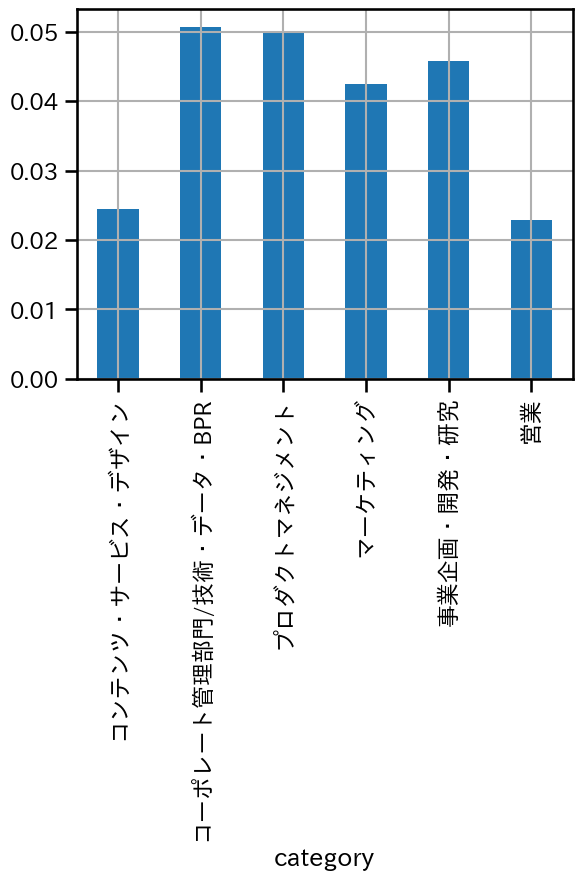

In [150]:
# ÂàùÊâã„ÅÆÂèØË¶ñÂåñ„ÅØÁõÆÁöÑÂ§âÊï∞„Åã„Çâ„ÄÇÁõÆÁöÑÂ§âÊï∞„Åå„Å©„ÅÆ„Åè„Çâ„ÅÑ„ÅÆÈ†ªÂ∫¶„ÅßÂá∫„Å¶„Åç„Å¶„ÅÑ„Çã„ÅÆ„Åã
ax = df_train.groupby("category")["target"].mean().plot(kind="bar")
ax.grid()

ÁõÆÁöÑÂ§âÊï∞„ÅÆÂèØË¶ñÂåñ„Åã„Çâ„ÄÅ„Éù„Ç∏„ÉÜ„Ç£„Éñ„Éá„Éº„Çø„ÅåÂÖ®‰Ωì„ÅÆ2ÔΩû5ÔºÖ„Å®„Å®„Å¶„ÇÇÂ∞ë„Å™„ÅÑ„Åì„Å®„ÅåÂàÜ„Åã„Çã


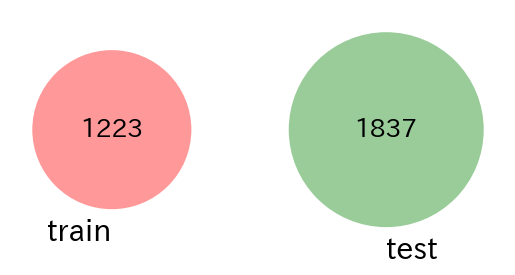

In [151]:
# „Éá„Éº„Çø„ÅÆÈáç„Å™„Çä„ÅÆÂèØË¶ñÂåñ
# train„Éá„Éº„Çø„Å®test„Éá„Éº„Çø„ÅßÁ§æÂì°„Å´Èáç„Å™„Çä„ÅåÁÑ°„ÅÑ„Åã„ÇíÁ¢∫Ë™ç
venn2(subsets=(set(df_train["Á§æÂì°Áï™Âè∑"].unique()), set(df_test["Á§æÂì°Áï™Âè∑"].unique())), set_labels=("train", "test"))

train„Éá„Éº„Çø„Å®test„Éá„Éº„Çø„ÅßÁ§æÂì°„Å´Èáç„Å™„Çä„ÅåÁÑ°„ÅÑ„Åì„Å®„ÅåÂàÜ„Åã„Çã„ÄÇ

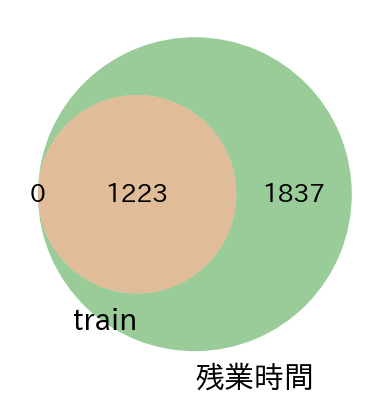

In [152]:
# ÊÆãÊ•≠ÊôÇÈñì„Åî„Å®„Å´ÂøúÂãü„Ç´„ÉÜ„Ç¥„É™„ÅÆÂøúÂãüÁéá„ÅØ„Å©„ÅÜ„Å™„Å£„Å¶„ÅÑ„Çã„ÅÆ„ÅãÔºü„Éô„É≥Âõ≥„ÇíÊõ∏„ÅÑ„Å¶„Åø„Çã
venn2(subsets=(set(df_train["Á§æÂì°Áï™Âè∑"].unique()), set(df_overtime["Á§æÂì°Áï™Âè∑"].unique())), set_labels=("train", "ÊÆãÊ•≠ÊôÇÈñì"))


ÊÆãÊ•≠ÊôÇÈñì„ÅåÁÑ°„ÅÑ„Çà„ÅÜ„Å™train„Éá„Éº„Çø„ÅØÁÑ°„ÅÑ„ÄÇ
ÊÆãÊ•≠ÊôÇÈñì„ÅÆÊ¨†Êêç„ÅåÁÑ°„ÅÑ„ÅÆ„Åß„ÄÅ„Çà„ÇäÊ©üÊ¢∞Â≠¶Áøí„Å´‰Ωø„ÅÑ„ÇÑ„Åô„ÅÑ„ÄÇ

‰ªñ„ÅÆ„Éô„É≥Âõ≥„ÇÇ‰Ωú„Å£„Å¶„Åø„Çã

C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1820460831.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z= df_train.groupby([hours, "category"])["target"].mean().unstack()


<Axes: xlabel='category', ylabel='Á§æÂì°Áï™Âè∑'>

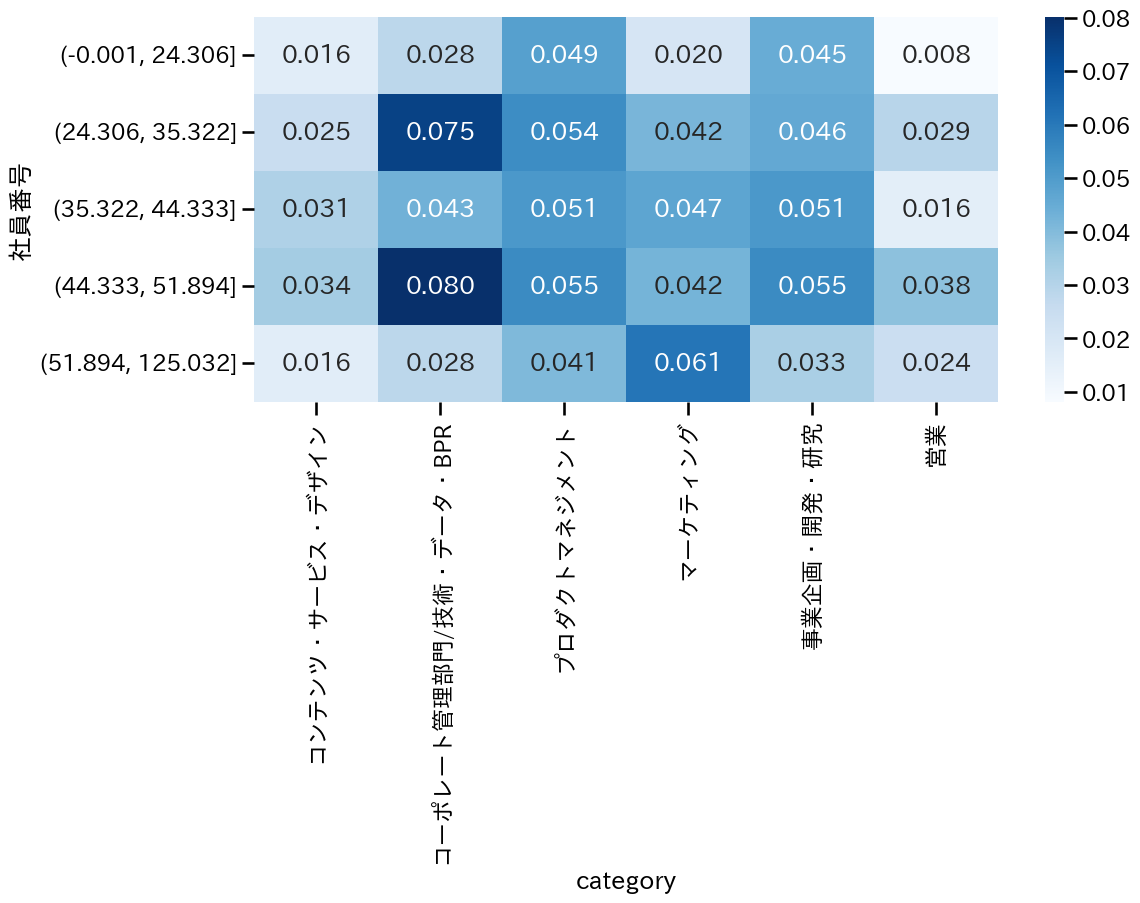

In [153]:
# Á§æÂì°„Åî„Å®„Å´Âπ≥ÂùáÊÆãÊ•≠ÊôÇÈñì„ÇíÊ±Ç„ÇÅ„Çã
mean_hours_by_workers = df_overtime.groupby("Á§æÂì°Áï™Âè∑")["hours"].mean()

# q-cut„ÅØquantile cut„ÅÆÁï•„Åß„ÄÅÈÄ£Á∂öÂú∞„ÇíÊõ∏„ÅèÂπÖ„ÅåÂêå„Åò„Åè„Çâ„ÅÑ„ÅÆ„Éá„Éº„Çø„Å´„Å™„Çã„Çà„ÅÜ„Å´Âå∫Âàá„Å£„Å¶„Åè„Çå„Çã
mean_hours_by_workers = pd.qcut(mean_hours_by_workers, q=5)
hours =df_train["Á§æÂì°Áï™Âè∑"].map(mean_hours_by_workers)

# Á∏¶Ëª∏„Åå1‰∫∫ÂΩì„Åü„Çä„ÅÆÊÆãÊ•≠ÊôÇÈñì„Å®„Å™„Çã
z= df_train.groupby([hours, "category"])["target"].mean().unstack()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, cmap="Blues", annot=True, fmt=".3f", ax=ax)

Á§æÂì°„Åî„Å®„ÅÆÊÆãÊ•≠ÊôÇÈñì„ÅÆÂèØË¶ñÂåñ„Å´„Çà„Çä„ÄÅ
„Éª„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞„ÅØÊÆãÊ•≠ÊôÇÈñì„ÅåÂ¢ó„Åà„Çã„Å®ÂÖ¨Âãü„ÅåÂ¢ó„Åà„Çã
„ÉªPdM„ÇÑ‰∫ãÊ•≠‰ºÅÁîª„ÅØÊÆãÊ•≠ÊôÇÈñì„Å´Èñ¢„Çè„Çâ„Åö„ÄÇ
„Éª„Ç≥„É≥„ÉÜ„É≥„ÉÑ„ÇÑÂñ∂Ê•≠„ÅØÁúü„Çì‰∏≠„Å´„Éî„Éº„ÇØ„Åå„ÅÇ„Çã
„Éª„Ç≥„Éº„Éù„É¨„Éº„Éà„ÅØÁúü„Çì‰∏≠„Å´„Éî„Éº„ÇØ„Åå„ÅÇ„Çã„ÄÇ
‰∏≠Á®ãÂ∫¶„ÅÆÊÆãÊ•≠ÊôÇÈñì„ÇíÊåÅ„Å£„Å¶„ÅÑ„Çã‰∫∫„ÅåÂÖ¨Âãü„Å´Êâã„Çí‰∏ä„Åí„ÇÑ„Åô„ÅÑ

## ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞Ôºödf_position


In [154]:
# Á§æÂì°Áï™Âè∑„ÅÆÂπ¥Â∫¶„ÅÆÊúÄÂ§ß„Åã„ÇâÊúÄÂ∞è„ÇíÂºï„Åè„Å®Âú®Á±çÂπ¥Êï∞„Å´„Å™„Çã
df_position_working_years = df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].max() - df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].min()
print(df_position_working_years)

# Âú®Á±çÂπ¥Êï∞„Çí„ÅÇ„Çâ„Åü„Å™ÁâπÂæ¥Èáè„Å®„Åô„ÇãÈñ¢Êï∞„Çí‰ΩúÊàê
def merge_by_worker_id(left, right):
    return pd.merge(left["Á§æÂì°Áï™Âè∑"], right, on="Á§æÂì°Áï™Âè∑", how="left").drop(columns=["Á§æÂì°Áï™Âè∑"])


Á§æÂì°Áï™Âè∑
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    2
-4taxxVbT1nU-J5fHWmDfQ==    2
-5W_JQCSTAYe2gGJMuT4_w==    2
                           ..
zuplFpzBoM4c1dFy5HPXqg==    2
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    2
zxY0Eflwm1tYj1Wt6vo_1g==    2
zxmtr2h4ypvsNq02K9AMJg==    2
Name: year, Length: 3060, dtype: int64


In [155]:
# Á§æÂì°Áï™Âè∑„ÅÆÂΩπËÅ∑„ÅÆ„É¶„Éã„Éº„ÇØÊï∞„ÇíÊï∞„Åà„Çå„Å∞„ÄÅÂΩπËÅ∑„ÅåÂ§âÂåñ„Åó„Åü‰∫∫„Åå„ÅÑ„Çã
# 1„Å™„Çâ„Åö„Å£„Å®Âêå„ÅòÂΩπËÅ∑„ÄÇ3„Å™„ÇâÂπ¥Â∫¶„Åî„Å®„Å´ÂÖ®ÈÉ®ÈÅï„ÅÜÂΩπËÅ∑
df_position_position_count= df_position.groupby("Á§æÂì°Áï™Âè∑")["ÂΩπËÅ∑"].nunique()
print(df_position_position_count)

# ÂΩπËÅ∑„ÅÆÂ§âÂåñ„ÇíÊñ∞„Åü„Å™ÁâπÂæ¥Èáè„Å®„Åó„Å¶ËøΩÂä†
# agg„ÅØagrigation„ÅßÈõÜÁ¥ÑÊÉÖÂ†±„Å®„ÅÑ„ÅÜÊÑèÂë≥
# ÂÉç„ÅÑ„Å¶„ÅÑ„ÇãÂπ¥Êï∞„Å®„Éù„Ç∏„Ç∑„Éß„É≥„ÇíÂ§â„Åà„ÅüÂπ¥Êï∞„ÅØ‰ΩïÂõû„ÅÇ„Çã„Åã„ÇíÈõÜË®à„Åô„ÇãÈñ¢Êï∞
def create_positon_aggregation_feture(input_df):
    agg = pd.concat([
        (df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].max() - df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].min()),
        df_position.groupby("Á§æÂì°Áï™Âè∑")["ÂΩπËÅ∑"].nunique().rename("change_positon_count")
    ], axis=1)

    return merge_by_worker_id(input_df, agg)

create_positon_aggregation_feture(df_train)

Á§æÂì°Áï™Âè∑
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    1
-4taxxVbT1nU-J5fHWmDfQ==    1
-5W_JQCSTAYe2gGJMuT4_w==    1
                           ..
zuplFpzBoM4c1dFy5HPXqg==    1
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    1
zxY0Eflwm1tYj1Wt6vo_1g==    1
zxmtr2h4ypvsNq02K9AMJg==    1
Name: ÂΩπËÅ∑, Length: 3060, dtype: int64


year  change_positon_count
0        1                     1
1        1                     1
2        1                     1
3        1                     1
4        1                     1
...    ...                   ...
7333     2                     1
7334     2                     1
7335     2                     1
7336     2                     1
7337     2                     1

[7338 rows x 2 columns]

In [156]:
# ÂΩπËÅ∑„ÅÆÊúÄÁµÇÂπ¥Â∫¶„ÅÆ24Âπ¥Â∫¶„ÅÆÂΩπËÅ∑„ÅÆ„Åø„ÇíÂèñ„ÇäÂá∫„ÅôÔºàlast„Çí‰Ωø„ÅÜÔºâ
# „Ç¢„É≥„ÉÄ„Éº„Éê„Éº„ÅØ‰∏ÄÊôÇÁöÑ„Å™Â§âÊï∞„ÇíÂÆöÁæ©„Åô„Çã„Å®„Åç„Å´‰ªò„Åë„Çã„Åì„Å®„ÅåÂ§ö„ÅÑ
_df = df_position.groupby("Á§æÂì°Áï™Âè∑").last()
print(_df)
def create_career_one_hot_encoding_feature(input_df):
    column_name = "ÂΩπËÅ∑"
    unique_values = df_position[column_name].unique()
    _df = df_position.groupby("Á§æÂì°Áï™Âè∑").last()

    # ÂΩπËÅ∑„Çí„Ç´„ÉÜ„Ç¥„É™„Å´„Åô„Çã
    cat_series = pd.Categorical(_df[column_name], categories=unique_values)
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)

    df_dummy.columns = df_dummy.columns.tolist()
    df_dummy["Á§æÂì°Áï™Âè∑"] = _df.index

    return merge_by_worker_id(input_df, df_dummy)



print("---„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞ÂÆüÊñΩ---")
df_dummy = create_career_one_hot_encoding_feature(df_train)


                          year      Âã§ÂãôÂå∫ÂàÜ        ÂΩπËÅ∑
Á§æÂì°Áï™Âè∑                                              
-1sqs0GXzpPJuAVKHUUFgg==    24       Ê≠£Á§æÂì°  „Ç∞„É´„Éº„Éó„É™„Éº„ÉÄ„Éº
-2Sq3E0WkZj8pL7jxdL3Cg==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
-4jh26kLzkU8JFQwdeQU9w==    24  Ê≠£Á§æÂì°(ÁÆ°ÁêÜËÅ∑)        Ë™≤Èï∑
-4taxxVbT1nU-J5fHWmDfQ==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
-5W_JQCSTAYe2gGJMuT4_w==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
...                        ...       ...       ...
zuplFpzBoM4c1dFy5HPXqg==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
zwcjIiu_sqUs8akLOfuYKA==    24  Ê≠£Á§æÂì°(ÁÆ°ÁêÜËÅ∑)        ÈÉ®Èï∑
zxPKKLM85QljzRfp0yisow==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
zxY0Eflwm1tYj1Wt6vo_1g==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
zxmtr2h4ypvsNq02K9AMJg==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨

[3060 rows x 3 columns]
---„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞ÂÆüÊñΩ---


<bound method _AxesBase.grid of <Axes: >>

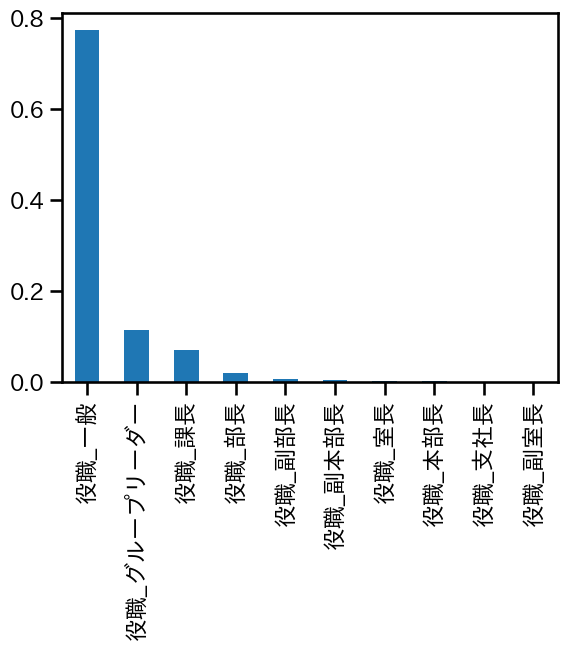

In [157]:
# „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞Âæå„ÅÆÂàÜÂ∏É
ax = df_dummy.mean().plot(kind="bar")
ax.grid

In [158]:
# 

# „Åì„ÅÆÈñ¢Êï∞„ÅØ„ÄÅinput_df „Å®„ÅÑ„ÅÜÂêçÂâç„ÅßPandas„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É† (pd.DataFrame) „ÇíÂèó„ÅëÂèñ„Çä„Åæ„Åô
def create_category_one_hot_encoding_feture(input_df: pd.DataFrame):
    # Âàó„ÅÆÂêçÂâç ("category") „Çí„ÄÅcolumn_name „Å®„ÅÑ„ÅÜÂ§âÊï∞„Å´Ê†ºÁ¥ç
    column_name = "category"
    # input_df „Éá„Éº„Çø„Éï„É¨„Éº„É†„Åã„Çâ category ÂàóÔºàinput_df[column_name]Ôºâ„ÇíÂèñ„ÇäÂá∫„Åó„ÄÅ
    # .unique() „Çí‰Ωø„Å£„Å¶ÈáçË§á„Åó„Å™„ÅÑ„Ç´„ÉÜ„Ç¥„É™„ÅÆÁ®ÆÈ°û„Çí„Åô„Åπ„Å¶„É™„Çπ„Éà„Ç¢„ÉÉ„Éó
    unique_values = input_df[column_name].unique()
    # category Âàó„Çí„Ç´„ÉÜ„Ç¥„É™Âûã„Éá„Éº„Çø„Å´Â§âÊèõ„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇ
    # categories=unique_values „Å®ÊåáÂÆö„Åô„Çã„Åì„Å®„Åß„ÄÅ„Ç´„ÉÜ„Ç¥„É™„ÅÆÈ†ÜÂ∫è„Çí unique_values „ÅÆÈ†ÜÁï™„Å´Âõ∫ÂÆö
    cat_series = pd.Categorical(input_df[column_name], categories=unique_values)
    # „Ç´„ÉÜ„Ç¥„É™Âûã„ÅÆ„Éá„Éº„Çø (cat_series) „ÇíÂèó„ÅëÂèñ„Çä„ÄÅ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÇíÂÆüË°å
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)
    # „Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂàóÂêçÔºàdf_dummy.columnsÔºâ„Çí‰∏ÄÂ∫¶„É™„Çπ„ÉàÂΩ¢Âºè„Å´Â§âÊèõ„Åó„ÄÅ
    # „Åù„Çå„ÇíÂÜçÂ∫¶ÂàóÂêç„Å®„Åó„Å¶Ë®≠ÂÆö„ÅóÁõ¥„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇÂøÖÈ†à„Åß„ÅØ„ÅÇ„Çä„Åæ„Åõ„Çì„ÄÇ
    df_dummy.columns = df_dummy.columns.tolist()
    
    return df_dummy

create_category_one_hot_encoding_feture(df_train)

category_„Ç≥„É≥„ÉÜ„É≥„ÉÑ„Éª„Çµ„Éº„Éì„Çπ„Éª„Éá„Ç∂„Ç§„É≥  category_„Ç≥„Éº„Éù„É¨„Éº„ÉàÁÆ°ÁêÜÈÉ®ÈñÄ/ÊäÄË°ì„Éª„Éá„Éº„Çø„ÉªBPR  \
0                         True                           False   
1                        False                            True   
2                        False                           False   
3                        False                           False   
4                        False                           False   
...                        ...                             ...   
7333                     False                            True   
7334                     False                           False   
7335                     False                           False   
7336                     False                           False   
7337                     False                           False   

      category_„Éó„É≠„ÉÄ„ÇØ„Éà„Éû„Éç„Ç∏„É°„É≥„Éà  category_„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞  category_‰∫ãÊ•≠‰ºÅÁîª„ÉªÈñãÁô∫„ÉªÁ†îÁ©∂  category_Âñ∂Ê•≠  
0                    False             False                False        False  
1                    False             False                False        False  
2                     True             False                False        False  
3                    False              True                False        False  
4                    False             False                 True        False  
...                    ...               ...                  ...          ...  
7333                 False             False                False        False  
7334                  True             False                False        False  
7335                 False              True                False        False  
7336                 False             False                 True        False  
7337                 False             False                False         True  

[7338 rows x 6 columns]

## career.csv„ÅÆÂä†Â∑•

In [159]:
# career.csv„ÅÆÂä†Â∑•
import re

# „Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')

# ÊúÄÂàù„Å´„ÄÅ„Åô„Åπ„Å¶„ÅÆ„Ç´„É©„É†Âêç„Åã„ÇâÂâçÂæå„ÅÆÁ©∫ÁôΩ„Å®ÊîπË°åÊñáÂ≠ó„ÇíÂâäÈô§„Åó„Åæ„Åô
df_career.columns = df_career.columns.str.strip()

# ÂõûÁ≠î„ÅÆÊñáÂ≠óÂàó„Åã„ÇâÂÖàÈ†≠„ÅÆÊï∞Â≠ó„ÇíÊäΩÂá∫„Åô„ÇãÈñ¢Êï∞
def extract_score(value):
    # ÂÄ§„ÅåÊñáÂ≠óÂàó„Åß„Å™„ÅÑÂ†¥ÂêàÔºà‰æã: Á©∫ÁôΩÔºâ„ÇÇËÄÉÊÖÆ
    if not isinstance(value, str):
        return np.nan
    
    # Ê≠£Ë¶èË°®Áèæ„ÅßÊñáÂ≠óÂàó„ÅÆÂÖàÈ†≠„Å´„ÅÇ„ÇãÊï∞Â≠óÔºà\dÔºâ„ÇíÊ§úÁ¥¢
    match = re.search(r'^\d', value.strip())
    
    if match:
        # Êï∞Â≠ó„ÅåË¶ã„Å§„Åã„Å£„ÅüÂ†¥Âêà„ÄÅÊï¥Êï∞„Å´Â§âÊèõ„Åó„Å¶Ëøî„Åô
        return int(match.group(0))
    else:
        # Êï∞Â≠ó„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅØNaNÔºàÊ¨†ÊêçÂÄ§Ôºâ„ÇíËøî„Åô
        return np.nan

# Á§æÂì°Áï™Âè∑‰ª•Â§ñ„ÅÆ„Åô„Åπ„Å¶„ÅÆÂàó„Å´Èñ¢Êï∞„ÇíÈÅ©Áî®
# df_career.columns[1:] „ÅØ„Äå1ÂàóÁõÆ‰ª•Èôç„ÅÆ„Åô„Åπ„Å¶„ÅÆÂàó„Äç„Å®„ÅÑ„ÅÜÊÑèÂë≥
for col in df_career.columns[1:]:
    df_career[col] = df_career[col].apply(extract_score)

# „Çπ„Ç≥„Ç¢„ÇíÂèçËª¢„Åï„Åõ„Çã„Ç´„É©„É†„ÅÆ„É™„Çπ„Éà
reverse_cols = [
    "Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ\n",
    "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ\n",
    "Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã\n",
    "„Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ\n"
]

# „Ç´„É©„É†Âêç„Å´ÊîπË°åÊñáÂ≠ó„ÅåÂê´„Åæ„Çå„Å¶„ÅÑ„Çã„Å®Ë°®Á§∫„ÅåÂ¥©„Çå„Çã„Åì„Å®„Åå„ÅÇ„Çã„Åü„ÇÅ„ÄÅ
# Ë°®Á§∫Áî®„Å´ÊîπË°å„ÇíÂâäÈô§„Åó„Åü„Ç´„É©„É†Âêç„ÅÆ„É™„Çπ„Éà„Çí‰ΩúÊàê
display_cols = [col.strip() for col in reverse_cols]
# ÂÖÉ„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆ„Ç´„É©„É†Âêç„ÇÇ‰∏ÄÊôÇÁöÑ„Å´‰øÆÊ≠£
df_career.columns = [col.strip() if col in reverse_cols else col for col in df_career.columns]


print("--- üî¢ „Çπ„Ç≥„Ç¢ÂèçËª¢Ââç„ÅÆ„Éá„Éº„Çø ---")
print(df_career[display_cols].head())

# ÂØæË±°„Å®„Å™„ÇãÂêÑ„Ç´„É©„É†„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèçËª¢„Åï„Åõ„Çã
for col in display_cols:
    if col in df_career.columns:
        df_career[col] = 6 - df_career[col]
    else:
        print(f"Ë≠¶Âëä: „Ç´„É©„É† '{col.strip()}' „ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")

print("\n" + "="*50 + "\n")

print("--- üîÑ „Çπ„Ç≥„Ç¢ÂèçËª¢Âæå„ÅÆ„Éá„Éº„Çø ---")
print(df_career[display_cols].head())

# Âá¶ÁêÜÂæå„ÅÆ„Éá„Éº„Çø„ÇíÁ¢∫Ë™ç
print("--- ÂÖ®„Å¶„ÅÆÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„ÅüÂæå„ÅÆ„Éá„Éº„Çø ---")
print(df_career.head())

# ÂêÑ„Ç´„ÉÜ„Ç¥„É™„Å´Â±û„Åô„Çã„Ç´„É©„É†Âêç„ÅÆ„É™„Çπ„Éà„ÇíÂÆöÁæ©
feature_groups = {
    "ËÅ∑Ê•≠ÁöÑËá™Â∑±„Ç§„É°„Éº„Ç∏„ÅÆÊòéÁ¢∫„Åï": [
        "Ëá™ÂàÜ„ÅÆËÉΩÂäõ„ÇíÁô∫ÊèÆ„Åß„Åç„Çã‰ªï‰∫ã‰∏ä„ÅÆÂæóÊÑèÂàÜÈáé„ÅåË¶ã„Å§„Åã„Å£„Å¶„ÅÑ„Çã",
        "Ëá™ÂàÜ„ÅØ„Å©„Çì„Å™‰ªï‰∫ã„Çí„ÇÑ„Çä„Åü„ÅÑ„ÅÆ„ÅãÊòé„Çâ„Åã„Åß„ÅÇ„Çã",
        "Ëá™ÂàÜ„ÅØ‰Ωï„ÇíÊúõ„Çì„Åß‰ªä„ÅÆ‰ªï‰∫ã„Çí„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åã„Çè„Åã„Å£„Å¶„ÅÑ„Çã",
        "Ëá™ÂàÜ„Å™„Çä„ÅÆËÅ∑Ê•≠ÁöÑ„Å™Áîü„ÅçÊñπ„Å´Èñ¢„Åô„ÇãÁõÆÊ®ô„ÉªÁõÆÁöÑ„Åå„ÅØ„Å£„Åç„Çä„Åó„Å¶„ÅÑ„Çã"
    ],
    "‰∏ª‰ΩìÁöÑ„Ç≠„É£„É™„Ç¢ÂΩ¢ÊàêÊÑèÊ¨≤": [
        "Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ",
        "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„ÄÅ„Çà„ÇäÂÖÖÂÆü„Åó„Åü„ÇÇ„ÅÆ„Å´„Åó„Åü„ÅÑ„Å®Âº∑„ÅèÊÄù„ÅÜ",
        "„Ç≠„É£„É™„Ç¢Ë®≠Ë®àÔºàËÅ∑Ê•≠ÁîüÊ¥ª„ÅÆË®≠Ë®àÔºâ„ÅØ„ÄÅËá™ÂàÜ„Å´„Å®„Å£„Å¶ÈáçË¶Å„Å™Ë™≤È°å„Åß„ÅÇ„Çã",
        "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ"
    ],
    "„Ç≠„É£„É™„Ç¢„ÅÆËá™Â∑±Ë≤¨‰ªªËá™Ë¶ö": [
        "Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Çã„Åã„Å©„ÅÜ„Åã„ÅØ„ÄÅËá™ÂàÜ„ÅÆË≤¨‰ªª„Å†„Å®ÊÄù„ÅÜ",
        "„Ç≠„É£„É™„Ç¢ÂΩ¢Êàê„ÅØ„ÄÅËá™ÂàÜËá™Ë∫´„ÅÆË≤¨‰ªª„Åß„ÅÇ„Çã",
        "Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã",
        "„Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ"
    ],
    "ËÅ∑Â†¥Áí∞Â¢ÉÂ§âÂåñ„Å∏„ÅÆÈÅ©ÂøúË°åÂãï": [
        "Êñ∞„Åó„ÅÑÁí∞Â¢É„ÇÑÁä∂Ê≥Å„Å´„ÇÇ„ÄÅ„Çè„Çä„ÅÇ„ÅÑÊó©„Åè„Å™„Åò„Çì„ÅßÂØæÂøú„Åó„Å¶„ÅÑ„Çã",
        "ËÅ∑Â†¥Áí∞Â¢É„ÅÆÂ§âÂåñ„Å´ÂØæ„Åó„Å¶Ëá™ÂàÜ„Å™„Çä„Å´ËÄÉ„Åà„Å¶ÂØæÂøú„Åó„Å¶„ÅÑ„Çã",
        "Êñ∞„Åó„ÅÑËÅ∑Â†¥„Å´Áßª„Å£„Å¶„ÇÇ„Åô„Åê„Å´Ëá™ÂàÜ„Çâ„Åó„Åï„ÇíÁô∫ÊèÆ„Åó„Å¶„ÅÑ„Çã",
        "ËÅ∑Â†¥„ÅÆÂà∂Â∫¶„ÇÑ‰ªï‰∫ã„ÅåÂ§â„Çè„Å£„Å¶„ÇÇ„Åô„ÅêÂØæÂøú„Åó„Å¶„ÅÑ„Çã"
    ],
    "„Ç≠„É£„É™„Ç¢ÈñãÁô∫Ë°åÂãï": [
        "Ëá™ÂàÜ„ÅÆËÅ∑Á®Æ„ÉªÊ•≠ÁïåÂàÜÈáé„Å´„Åä„Åë„ÇãÊúÄÊñ∞ÂãïÂêë„ÇíÂ∏∏„Å´ÊÉÖÂ†±ÂèéÈõÜ„Åó„Å¶„ÅÑ„Çã",
        "‰ªï‰∫ã„ÅÆ„Åü„ÇÅ„Å´Êñ∞„Åó„ÅÑ„Åì„Å®„Çí„ÅÑ„Çç„ÅÑ„ÇçÂãâÂº∑„Åó„Å¶„ÅÑ„Çã",
        "Á§æ‰ºö„ÉªÁµåÊ∏à„ÅÆÂãï„Åç„ÇÑÊàê„ÇäË°å„Åç„Å´Èñ¢„Åô„ÇãÊÉÖÂ†±„Çí„ÄÅÁ©çÊ•µÁöÑ„Å´ÂèéÈõÜ„Åó„Å¶„ÅÑ„Çã",
        "Êñ∞„Åó„ÅÑÁü•Ë≠ò„ÉªÊäÄË°ì„ÇíÁ©çÊ•µÁöÑ„Å´Â≠¶„Å∂„Çà„ÅÜ„Å´Âä™„ÇÅ„Å¶„ÅÑ„Çã"
    ],
    "„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØË°åÂãï": [
        "Êñ∞„Åó„ÅÑ‰∫∫ÈñìÈñ¢‰øÇ„ÅåÊßãÁØâ„Åß„Åç„Çã„Çà„ÅÜ„Å´„ÄÅÁ§æÂÜÖÂ§ñ„ÅÆÊ¥ªÂãï„Å´Á©çÊ•µÁöÑ„Å´ÂèÇÂä†„Åó„Å¶„ÅÑ„Çã",
        "‰ªï‰∫ã„Å®Áõ¥Êé•Èñ¢‰øÇ„Å™„ÅÑ‰∫∫„Å®„ÇÇÁ©çÊ•µÁöÑ„Å´‰∫§ÊµÅ„Åô„Çã„Çà„ÅÜ„Å´„Åó„Å¶„ÅÑ„Çã",
        "Êñ∞„Åó„ÅÑ„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ„Å•„Åè„Çä„Å´Â∏∏„Å´Âèñ„ÇäÁµÑ„Çì„Åß„ÅÑ„Çã"
    ],
    "‰∏ª‰ΩìÁöÑ‰ªï‰∫ãË°åÂãï": [
        "Ëá™ÂàÜ„ÅÆÊ∫ÄË∂≥ÊÑü„ÇíÈ´ò„ÇÅ„Çã„Çà„ÅÜ„Å´„ÄÅ‰ªï‰∫ã„ÅÆ„ÇÑ„ÇäÊñπ„ÇíÂ∑•Â§´„Åó„Å¶„ÅÑ„Çã",
        "Â∏∏„Å´Ëá™Áô∫ÁöÑ„Å´‰ªï‰∫ã„ÇíË°å„Å£„Å¶„ÅÑ„Çã",
        "Ëá™ÂàÜ„ÅÆ‰æ°ÂÄ§Ë¶≥„ÇÑ„Éù„É™„Ç∑„Éº„ÇíÊåÅ„Å£„Å¶‰ªï‰∫ã„Å´Âèñ„ÇäÁµÑ„Çì„Åß„ÅÑ„Çã",
        "‰ªï‰∫ã„ÅÆÈÄ≤„ÇÅÊñπ„ÇÑ‰ºÅÁîª„ÇíÁ´ã„Å¶„Çã‰∏ä„Åß„ÄÅ‰ªä„Åæ„Åß„ÅÆÂª∂Èï∑‰∏ä„ÅÆ„ÇÑ„ÇäÊñπ„Åß„ÅØ„Å™„Åè„ÄÅËá™ÂàÜ„Å™„Çä„ÅÆÁô∫ÊÉ≥„ÇíÊåÅ„Å£„Å¶Âèñ„ÇäÁµÑ„Çì„Åß„ÅÑ„Çã"
    ]
}

# Êñ∞„Åó„ÅÑÂêàË®àÁÇπ„ÅÆ„Ç´„É©„É†„Çí‰ΩúÊàê
for new_col_name, group_cols in feature_groups.items():
    # .sum(axis=1) „ÅßË°å„Åî„Å®„Å´ÂêàË®àÁÇπ„ÇíË®àÁÆó
    df_career[new_col_name] = df_career[group_cols].sum(axis=1, min_count=1) # 1„Å§„Åß„ÇÇÊúâÂäπ„Å™ÂÄ§„Åå„ÅÇ„Çå„Å∞ÂêàË®à


# --- Step 3: ÁµêÊûú„ÅÆÁ¢∫Ë™ç ---
print("--- ‰ΩúÊàê„Åï„Çå„ÅüÊñ∞„Åó„ÅÑÁâπÂæ¥ÈáèÔºàÂêàË®àÁÇπÔºâ ---")

# ‰ΩúÊàê„Åó„ÅüÊñ∞„Åó„ÅÑ„Ç´„É©„É†Âêç„Å†„Åë„ÅÆ„É™„Çπ„Éà
new_feature_columns = list(feature_groups.keys())
# Á§æÂì°Áï™Âè∑„Å®Êñ∞„Åó„ÅÑ„Ç´„É©„É†„Å†„Åë„ÇíË°®Á§∫
print(df_career[["Á§æÂì°Áï™Âè∑"] + new_feature_columns].head())


--- üî¢ „Çπ„Ç≥„Ç¢ÂèçËª¢Ââç„ÅÆ„Éá„Éº„Çø ---
   Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ  „Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ  \
0                        4                            3   
1                        1                            1   
2                        1                            1   
3                        5                            1   
4                        2                            2   

   Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã  „Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ  
0                            3                            5  
1                            1                            1  
2                            1                            1  
3                            1                            1  
4                            1                            2  


--- üîÑ „Çπ„Ç≥„Ç¢Â

In [160]:
# create_career_summary_feature „Å®„ÅÑ„ÅÜÈñ¢Êï∞„Çí‰ΩúÊàê(‰∏äË®ò„Å®Âêå„ÅòÂá¶ÁêÜ)
def create_career_summary_feature(input_df: pd.DataFrame, career_csv_path: str):
    """
    career.csv„ÇíË™≠„ÅøËæº„Åø„ÄÅ„Çπ„Ç≥„Ç¢„ÅÆÊäΩÂá∫„ÄÅÈÄÜËª¢È†ÖÁõÆ„ÅÆÂá¶ÁêÜ„ÄÅ
    „Ç´„ÉÜ„Ç¥„É™„Åî„Å®„ÅÆÂêàË®àÁÇπ„ÅÆÁÆóÂá∫„ÇíË°å„ÅÑ„ÄÅinput_df„Å´ÁµêÂêà„Åó„Å¶Ëøî„ÅôÈñ¢Êï∞
    """
    # --- Step 1: career.csv„ÅÆË™≠„ÅøËæº„Åø„Å®ÂâçÂá¶ÁêÜ ---
    try:
        df_career = pd.read_csv(career_csv_path, encoding='utf-8-sig')
    except FileNotFoundError:
        print(f"'{career_csv_path}' „ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„ÄÇÂá¶ÁêÜ„Çí„Çπ„Ç≠„ÉÉ„Éó„Åó„Åæ„Åô„ÄÇ")
        return input_df # „Éï„Ç°„Ç§„É´„Åå„Å™„ÅÑÂ†¥Âêà„ÅØÂÖÉ„ÅÆdf„Çí„Åù„ÅÆ„Åæ„ÅæËøî„Åô

    df_career.columns = df_career.columns.str.strip()

    def extract_score(value):
        if not isinstance(value, str): return np.nan
        match = re.search(r'\d', value)
        if match: return int(match.group(0))
        else: return np.nan

    for col in df_career.columns[1:]:
        df_career[col] = df_career[col].apply(extract_score)

    reverse_cols = [
        "Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ", "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ",
        "Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã", "„Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ"
    ]
    for col in reverse_cols:
        if col in df_career.columns:
            df_career[col] = 6 - df_career[col]

    # --- Step 2: ÊåáÂÆö„Åï„Çå„ÅüÈ†ÖÁõÆ„ÇíÂêàË®à„Åó„Å¶Êñ∞„Åó„ÅÑÁâπÂæ¥Èáè„Çí‰ΩúÊàê ---
    feature_groups = {
        "ËÅ∑Ê•≠ÁöÑËá™Â∑±„Ç§„É°„Éº„Ç∏„ÅÆÊòéÁ¢∫„Åï": ["Ëá™ÂàÜ„ÅÆËÉΩÂäõ„ÇíÁô∫ÊèÆ„Åß„Åç„Çã‰ªï‰∫ã‰∏ä„ÅÆÂæóÊÑèÂàÜÈáé„ÅåË¶ã„Å§„Åã„Å£„Å¶„ÅÑ„Çã", "Ëá™ÂàÜ„ÅØ„Å©„Çì„Å™‰ªï‰∫ã„Çí„ÇÑ„Çä„Åü„ÅÑ„ÅÆ„ÅãÊòé„Çâ„Åã„Åß„ÅÇ„Çã", "Ëá™ÂàÜ„ÅØ‰Ωï„ÇíÊúõ„Çì„Åß‰ªä„ÅÆ‰ªï‰∫ã„Çí„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åã„Çè„Åã„Å£„Å¶„ÅÑ„Çã", "Ëá™ÂàÜ„Å™„Çä„ÅÆËÅ∑Ê•≠ÁöÑ„Å™Áîü„ÅçÊñπ„Å´Èñ¢„Åô„ÇãÁõÆÊ®ô„ÉªÁõÆÁöÑ„Åå„ÅØ„Å£„Åç„Çä„Åó„Å¶„ÅÑ„Çã"],
        "‰∏ª‰ΩìÁöÑ„Ç≠„É£„É™„Ç¢ÂΩ¢ÊàêÊÑèÊ¨≤": ["Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ", "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„ÄÅ„Çà„ÇäÂÖÖÂÆü„Åó„Åü„ÇÇ„ÅÆ„Å´„Åó„Åü„ÅÑ„Å®Âº∑„ÅèÊÄù„ÅÜ", "„Ç≠„É£„É™„Ç¢Ë®≠Ë®àÔºàËÅ∑Ê•≠ÁîüÊ¥ª„ÅÆË®≠Ë®àÔºâ„ÅØ„ÄÅËá™ÂàÜ„Å´„Å®„Å£„Å¶ÈáçË¶Å„Å™Ë™≤È°å„Åß„ÅÇ„Çã", "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ"],
        "„Ç≠„É£„É™„Ç¢„ÅÆËá™Â∑±Ë≤¨‰ªªËá™Ë¶ö": ["Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Çã„Åã„Å©„ÅÜ„Åã„ÅØ„ÄÅËá™ÂàÜ„ÅÆË≤¨‰ªª„Å†„Å®ÊÄù„ÅÜ", "„Ç≠„É£„É™„Ç¢ÂΩ¢Êàê„ÅØ„ÄÅËá™ÂàÜËá™Ë∫´„ÅÆË≤¨‰ªª„Åß„ÅÇ„Çã", "Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã", "„Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ"],
        "ËÅ∑Â†¥Áí∞Â¢ÉÂ§âÂåñ„Å∏„ÅÆÈÅ©ÂøúË°åÂãï": ["Êñ∞„Åó„ÅÑÁí∞Â¢É„ÇÑÁä∂Ê≥Å„Å´„ÇÇ„ÄÅ„Çè„Çä„ÅÇ„ÅÑÊó©„Åè„Å™„Åò„Çì„ÅßÂØæÂøú„Åó„Å¶„ÅÑ„Çã", "ËÅ∑Â†¥Áí∞Â¢É„ÅÆÂ§âÂåñ„Å´ÂØæ„Åó„Å¶Ëá™ÂàÜ„Å™„Çä„Å´ËÄÉ„Åà„Å¶ÂØæÂøú„Åó„Å¶„ÅÑ„Çã", "Êñ∞„Åó„ÅÑËÅ∑Â†¥„Å´Áßª„Å£„Å¶„ÇÇ„Åô„Åê„Å´Ëá™ÂàÜ„Çâ„Åó„Åï„ÇíÁô∫ÊèÆ„Åó„Å¶„ÅÑ„Çã", "ËÅ∑Â†¥„ÅÆÂà∂Â∫¶„ÇÑ‰ªï‰∫ã„ÅåÂ§â„Çè„Å£„Å¶„ÇÇ„Åô„ÅêÂØæÂøú„Åó„Å¶„ÅÑ„Çã"],
        "„Ç≠„É£„É™„Ç¢ÈñãÁô∫Ë°åÂãï": ["Ëá™ÂàÜ„ÅÆËÅ∑Á®Æ„ÉªÊ•≠ÁïåÂàÜÈáé„Å´„Åä„Åë„ÇãÊúÄÊñ∞ÂãïÂêë„ÇíÂ∏∏„Å´ÊÉÖÂ†±ÂèéÈõÜ„Åó„Å¶„ÅÑ„Çã", "‰ªï‰∫ã„ÅÆ„Åü„ÇÅ„Å´Êñ∞„Åó„ÅÑ„Åì„Å®„Çí„ÅÑ„Çç„ÅÑ„ÇçÂãâÂº∑„Åó„Å¶„ÅÑ„Çã", "Á§æ‰ºö„ÉªÁµåÊ∏à„ÅÆÂãï„Åç„ÇÑÊàê„ÇäË°å„Åç„Å´Èñ¢„Åô„ÇãÊÉÖÂ†±„Çí„ÄÅÁ©çÊ•µÁöÑ„Å´ÂèéÈõÜ„Åó„Å¶„ÅÑ„Çã", "Êñ∞„Åó„ÅÑÁü•Ë≠ò„ÉªÊäÄË°ì„ÇíÁ©çÊ•µÁöÑ„Å´Â≠¶„Å∂„Çà„ÅÜ„Å´Âä™„ÇÅ„Å¶„ÅÑ„Çã"],
        "„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØË°åÂãï": ["Êñ∞„Åó„ÅÑ‰∫∫ÈñìÈñ¢‰øÇ„ÅåÊßãÁØâ„Åß„Åç„Çã„Çà„ÅÜ„Å´„ÄÅÁ§æÂÜÖÂ§ñ„ÅÆÊ¥ªÂãï„Å´Á©çÊ•µÁöÑ„Å´ÂèÇÂä†„Åó„Å¶„ÅÑ„Çã", "‰ªï‰∫ã„Å®Áõ¥Êé•Èñ¢‰øÇ„Å™„ÅÑ‰∫∫„Å®„ÇÇÁ©çÊ•µÁöÑ„Å´‰∫§ÊµÅ„Åô„Çã„Çà„ÅÜ„Å´„Åó„Å¶„ÅÑ„Çã", "Êñ∞„Åó„ÅÑ„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ„Å•„Åè„Çä„Å´Â∏∏„Å´Âèñ„ÇäÁµÑ„Çì„Åß„ÅÑ„Çã"],
        "‰∏ªÁöÑ‰ªï‰∫ãË°åÂãï": ["Ëá™ÂàÜ„ÅÆÊ∫ÄË∂≥ÊÑü„ÇíÈ´ò„ÇÅ„Çã„Çà„ÅÜ„Å´„ÄÅ‰ªï‰∫ã„ÅÆ„ÇÑ„ÇäÊñπ„ÇíÂ∑•Â§´„Åó„Å¶„ÅÑ„Çã", "Â∏∏„Å´Ëá™Áô∫ÁöÑ„Å´‰ªï‰∫ã„ÇíË°å„Å£„Å¶„ÅÑ„Çã", "Ëá™ÂàÜ„ÅÆ‰æ°ÂÄ§Ë¶≥„ÇÑ„Éù„É™„Ç∑„Éº„ÇíÊåÅ„Å£„Å¶‰ªï‰∫ã„Å´Âèñ„ÇäÁµÑ„Çì„Åß„ÅÑ„Çã", "‰ªï‰∫ã„ÅÆÈÄ≤„ÇÅÊñπ„ÇÑ‰ºÅÁîª„ÇíÁ´ã„Å¶„Çã‰∏ä„Åß„ÄÅ‰ªä„Åæ„Åß„ÅÆÂª∂Èï∑‰∏ä„ÅÆ„ÇÑ„ÇäÊñπ„Åß„ÅØ„Å™„Åè„ÄÅËá™ÂàÜ„Å™„Çä„ÅÆÁô∫ÊÉ≥„ÇíÊåÅ„Å£„Å¶Âèñ„ÇäÁµÑ„Çì„Åß„ÅÑ„Çã"]
    }

    new_feature_columns = list(feature_groups.keys())
    for new_col_name, group_cols in feature_groups.items():
        df_career[new_col_name] = df_career[group_cols].sum(axis=1, min_count=1)

    # --- Step 3: input_df„Å´ÁµêÂêà ---
    # ÂøÖË¶Å„Å™„Ç´„É©„É†ÔºàÁ§æÂì°Áï™Âè∑„Å®Êñ∞„Åó„ÅÑÁâπÂæ¥ÈáèÔºâ„Å†„Åë„ÇíÊäΩÂá∫
    df_career_features = df_career[["Á§æÂì°Áï™Âè∑"] + new_feature_columns]
    
    # ÂÖÉ„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„Å´ÁµêÂêà„Åó„Å¶Ëøî„Åô
    output_df = pd.merge(input_df, df_career_features, on="Á§æÂì°Áï™Âè∑", how="left")
    
    return output_df


career_csv_path = os.path.join(INPUT_DIR, "career.csv")

# partial„Çí‰Ωø„Å£„Å¶„ÄÅcareer_csv_pathÂºïÊï∞„ÇíÂõ∫ÂÆö„Åó„ÅüÊñ∞„Åó„ÅÑÈñ¢Êï∞„Çí‰ΩúÊàê
create_career_summary_feature_fixed = partial(create_career_summary_feature, career_csv_path=career_csv_path)



## UdemyÂèóË¨õË®òÈå≤: udemy_activity.csv„ÅÆÂä†Â∑•

In [161]:
# --- 1. „Éá„Éº„Çø„ÅÆÂâçÂá¶ÁêÜ ---
print("--- „Éá„Éº„Çø„ÅÆÂâçÂá¶ÁêÜ„ÇíÈñãÂßã ---")

# 'ÈñãÂßãÊó•'„Å®'ÁµÇ‰∫ÜÊó•'„ÅÆÂàó„ÇíÊó•‰ªòÂûã„Å´Â§âÊèõ„Åó„Åæ„Åô
# Â§âÊèõ„Åß„Åç„Å™„ÅÑÂÄ§„ÅØNaTÔºàNot a TimeÔºâ„Å®„Åó„Å¶Êâ±„ÅÑ„Åæ„Åô
df_udemy['start_date'] = pd.to_datetime(df_udemy['ÈñãÂßãÊó•'], errors='coerce')
df_udemy['end_date'] = pd.to_datetime(df_udemy['ÁµÇ‰∫ÜÊó•'], errors='coerce')

# 'Êé®ÂÆöÂÆå‰∫ÜÁéá%'„Å®'ÊúÄÁµÇÁµêÊûúÔºà„ÇØ„Ç§„Ç∫„ÅÆÂ†¥ÂêàÔºâ'„ÇíÊï∞ÂÄ§Âûã„Å´Â§âÊèõ„Åó„Åæ„Åô
df_udemy['completion_rate_percent'] = pd.to_numeric(df_udemy['Êé®ÂÆöÂÆå‰∫ÜÁéá%'], errors='coerce')
df_udemy['quiz_result_percent'] = pd.to_numeric(df_udemy['ÊúÄÁµÇÁµêÊûúÔºà„ÇØ„Ç§„Ç∫„ÅÆÂ†¥ÂêàÔºâ'], errors='coerce')

# '„Éû„Éº„ÇØÊ∏à„Åø‰øÆ‰∫Ü'„ÇíTrue/False„Åã„Çâ1/0„ÅÆÊï¥Êï∞„Å´Â§âÊèõ„Åó„Åæ„Åô
df_udemy['is_completed_marked'] = df_udemy['„Éû„Éº„ÇØÊ∏à„Åø‰øÆ‰∫Ü'].astype(int)

print("Êó•‰ªòÂ§âÊèõ„Å®Êï∞ÂÄ§„ÇØ„É¨„É≥„Ç∏„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")
# df_udemy.head()

--- „Éá„Éº„Çø„ÅÆÂâçÂá¶ÁêÜ„ÇíÈñãÂßã ---
Êó•‰ªòÂ§âÊèõ„Å®Êï∞ÂÄ§„ÇØ„É¨„É≥„Ç∏„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ


‰ª•‰∏ã„ÅÆÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÂÆüÊñΩ
‚ñ†Â≠¶ÁøíÈáè„ÉªÂà©Áî®Áä∂Ê≥Å„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
„ÉªÁ∑èÂèóË¨õ„Ç≥„Éº„ÇπÊï∞Ôºö‰∏Ä‰∫∫„ÅÆÁ§æÂì°„Åå„ÅÑ„Åè„Å§„ÅÆ„É¶„Éã„Éº„ÇØ„Å™„Ç≥„Éº„Çπ„ÇíÂèóË¨õ„Åó„Åü„Åã„ÄÇ
„ÉªÁ∑èÂèóË¨õ„É¨„ÇØ„ÉÅ„É£„ÉºÊï∞ÔºöË¶ñËÅ¥„Åó„Åü„É¨„ÇØ„ÉÅ„É£„Éº„ÇÑÂèóÈ®ì„Åó„Åü„ÇØ„Ç§„Ç∫„ÅÆÁ∑èÊï∞
„ÉªÁ∑èÂ≠¶ÁøíÊôÇÈñìÔºöÂêÑ„É¨„ÇØ„ÉÅ„É£„Éº„ÅÆ ÁµÇ‰∫ÜÊó• - ÈñãÂßãÊó• „ÅÆÂêàË®àÊôÇÈñì„ÄÇÁÜ±ÂøÉ„Åï„ÅÆÊåáÊ®ô
„ÉªÂ≠¶ÁøíÂÆå‰∫ÜÁéáÔºö„Éû„Éº„ÇØÊ∏à„ÅøÁµÇ‰∫Ü „Åå True „ÅÆ„É¨„ÇØ„ÉÅ„É£„ÉºÊï∞„Çí„ÄÅÁ∑èÂèóË¨õ„É¨„ÇØ„ÉÅ„É£„ÉºÊï∞„ÅßÂâ≤„Å£„ÅüÂâ≤Âêà
‚ñ† Â≠¶ÁøíÂÜÖÂÆπ„ÉªÂàÜÈáé„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
„ÉªÂèóË¨õ„Ç´„ÉÜ„Ç¥„É™„ÅÆÂ§öÊßòÊÄßÔºöÂèóË¨õ„Åó„Åü„Ç≥„Éº„Çπ„Ç´„ÉÜ„Ç¥„É™„Éº„ÅÆ„É¶„Éã„Éº„ÇØÊï∞„ÄÇÊï∞„ÅåÂ§ö„ÅÑ„Åª„Å©„ÄÅÂπÖÂ∫É„ÅèÂ≠¶„Çì„Åß„ÅÑ„Çã
‚ñ† Â≠¶ÁøíÊàêÊûú„Éª„Éë„Éï„Ç©„Éº„Éû„É≥„Çπ„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
„Éª„É¨„ÇØ„ÉÅ„É£„Éº„ÅÆÂπ≥ÂùáÂÆå‰∫ÜÁéáÔºöË¶ñËÅ¥„Åó„Åü„Åô„Åπ„Å¶„ÅÆ„É¨„ÇØ„ÉÅ„É£„Éº„Å´„Åä„Åë„ÇãÊé®ÂÆöÂÆå‰∫ÜÁéá%„ÅÆÂπ≥ÂùáÂÄ§
‚ñ†ÊôÇÈñì„ÉªÊôÇÊúü„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
„ÉªÊúÄÁµÇÂ≠¶ÁøíÊó•„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞ÔºöÊúÄËøë„Ç¢„ÇØ„ÉÜ„Ç£„Éì„ÉÜ„Ç£„Åå„Å™„ÅÑÁ§æÂì°„ÅØ„ÄÅËààÂë≥„ÇíÂ§±„Å£„Å¶„ÅÑ„ÇãÂèØËÉΩÊÄß
„ÉªÂ≠¶ÁøíÊúüÈñìÔºöÊúÄÂàù„ÅÆÈñãÂßãÊó•„Åã„ÇâÊúÄÂæå„ÅÆÁµÇ‰∫ÜÊó•„Åæ„Åß„ÅÆÊúüÈñì„ÄÇÁ∂ôÁ∂öÁöÑ„Å´Â≠¶Áøí„Åó„Å¶„ÅÑ„Çã„Åã„Å©„ÅÜ„Åã
„ÉªÈÄ±Êú´„ÉªÂπ≥Êó•„ÅÆÂ≠¶ÁøíÊØîÁéáÔºöÊ•≠ÂãôÂ§ñ„Åß„ÅÆËá™Â∑±ÊäïË≥áÊÑèÊ¨≤„ÅÆÊåáÊ®ô„Å´„Å™„ÇãÂèØËÉΩÊÄß

In [162]:
# Á§æÂì°Áï™Âè∑„Åî„Å®„Å´ÈõÜÁ¥Ñ„Åô„Çã„Åü„ÇÅ„ÅÆÊ∫ñÂÇô„Çí„Åó„Åæ„Åô
agg_funcs = {
    # Á∑èÂèóË¨õ„Ç≥„Éº„ÇπÊï∞
    'total_courses': ('„Ç≥„Éº„ÇπID', 'nunique'),
    # Á∑èÂèóË¨õ„É¨„ÇØ„ÉÅ„É£„ÉºÊï∞
    'total_lectures': ('Á§æÂì°Áï™Âè∑', 'size'),
    # Â≠¶ÁøíÂÆå‰∫ÜÁéá
    'completion_rate_marked': ('is_completed_marked', 'mean'),
    # ÂèóË¨õ„Ç´„ÉÜ„Ç¥„É™„ÅÆÂ§öÊßòÊÄß
    'category_diversity': ('„Ç≥„Éº„Çπ„Ç´„ÉÜ„Ç¥„É™„Éº', 'nunique'),
    # „É¨„ÇØ„ÉÅ„É£„Éº„ÅÆÂπ≥ÂùáÂÆå‰∫ÜÁéá
    'avg_completion_rate_estimated': ('completion_rate_percent', 'mean'),
}

# groupby().agg() „Çí‰Ωø„Å£„Å¶„ÄÅ‰∏äË®ò„ÅÆÁâπÂæ¥Èáè„Çí‰∏ÄÂ∫¶„Å´Ë®àÁÆó„Åó„Åæ„Åô
df_udemy_features = df_udemy.groupby('Á§æÂì°Áï™Âè∑').agg(**agg_funcs)


# --- ÊôÇÈñìÈñ¢ÈÄ£„Å™„Å©„ÄÅÂÄãÂà•„Å´Ë®àÁÆó„ÅåÂøÖË¶Å„Å™ÁâπÂæ¥Èáè ---

# Á∑èÂ≠¶ÁøíÊôÇÈñìÔºàÂçò‰ΩçÔºöÊôÇÈñìÔºâ
df_udemy['duration_seconds'] = (df_udemy['end_date'] - df_udemy['start_date']).dt.total_seconds()
total_learning_hours = df_udemy.groupby('Á§æÂì°Áï™Âè∑')['duration_seconds'].sum() / 3600
df_udemy_features['total_learning_hours'] = total_learning_hours

# ÊúÄÁµÇÂ≠¶ÁøíÊó•„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞
latest_activity_date = df_udemy['end_date'].max()
days_since_last = (latest_activity_date - df_udemy.groupby('Á§æÂì°Áï™Âè∑')['end_date'].max()).dt.days
df_udemy_features['days_since_last_activity'] = days_since_last

# Â≠¶ÁøíÊúüÈñìÔºàÊúÄÂàù„Å®ÊúÄÂæå„ÅÆÂ≠¶ÁøíÊó•„ÅÆÂ∑ÆÔºâ
learning_period = (df_udemy.groupby('Á§æÂì°Áï™Âè∑')['end_date'].max() - df_udemy.groupby('Á§æÂì°Áï™Âè∑')['start_date'].min()).dt.days
df_udemy_features['learning_period_days'] = learning_period

# ÈÄ±Êú´„ÅÆÂ≠¶ÁøíÊØîÁéá
df_udemy['is_weekend'] = df_udemy['start_date'].dt.dayofweek.isin([5, 6]).astype(int)
weekend_ratio = df_udemy.groupby('Á§æÂì°Áï™Âè∑')['is_weekend'].mean()
df_udemy_features['weekend_learning_ratio'] = weekend_ratio

# Ë®àÁÆó„ÅÆÈÅéÁ®ã„ÅßÁô∫Áîü„Åó„ÅüÊ¨†ÊêçÂÄ§(NaN)„Çí0„ÅßÂüã„ÇÅ„Åæ„Åô
df_udemy_features.fillna(0, inplace=True)

print(f"\nÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

# ÁµêÊûú„ÅÆÁ¢∫Ë™ç„ÅÆ„Åü„ÇÅ„ÄÅ‰ΩúÊàê„Åï„Çå„Åü„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂÖàÈ†≠5Ë°å„ÇíË°®Á§∫„Åó„Åæ„Åô
print("\n--- ‰ΩúÊàê„Åï„Çå„ÅüÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É† (df_udemy_features) ---")
print(df_udemy_features.head())


ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ

--- ‰ΩúÊàê„Åï„Çå„ÅüÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É† (df_udemy_features) ---
                          total_courses  total_lectures  \
Á§æÂì°Áï™Âè∑                                                      
-1sqs0GXzpPJuAVKHUUFgg==              4              32   
-2Sq3E0WkZj8pL7jxdL3Cg==              5             194   
-4jh26kLzkU8JFQwdeQU9w==              2               2   
-4taxxVbT1nU-J5fHWmDfQ==             36             316   
-5W_JQCSTAYe2gGJMuT4_w==             17             146   

                          completion_rate_marked  category_diversity  \
Á§æÂì°Áï™Âè∑                                                                   
-1sqs0GXzpPJuAVKHUUFgg==                0.906250                   1   
-2Sq3E0WkZj8pL7jxdL3Cg==                0.989691                   5   
-4jh26kLzkU8JFQwdeQU9w==                0.500000                   1   
-4taxxVbT1nU-J5fHWmDfQ==                0.772152                  22   
-5W_

## hr.csv„ÅÆÂä†Â∑•

In [163]:
# ‚ñ†ÂèÇÂä†Èáè„Éª„Ç®„É≥„Ç≤„Éº„Ç∏„É°„É≥„Éà„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
# „ÉªÁ∑èÂèÇÂä†ÊñΩÁ≠ñÊï∞Ôºö‰∏Ä‰∫∫„ÅÆÁ§æÂì°„ÅåÂèÇÂä†„Åó„ÅüÁ†î‰øÆ„ÇÑÈù¢Ë´á„ÅÆÁ∑èÂõûÊï∞
# „Éª„É¶„Éã„Éº„ÇØ„Ç´„ÉÜ„Ç¥„É™ÂèÇÂä†Êï∞Ôºö‰ΩïÁ®ÆÈ°û„ÅÆ„Ç´„ÉÜ„Ç¥„É™„ÅÆÊñΩÁ≠ñ„Å´ÂèÇÂä†„Åó„Åü„Åã„ÄÇÂèÇÂä†„ÅÆÂπÖÂ∫É„Åï„ÇíÁ§∫„Åó„Åæ„Åô
# ‚ñ†ÂèÇÂä†ÂÜÖÂÆπ„ÉªÂàÜÈáé„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
# „ÉªÁâπÂÆö„Ç´„ÉÜ„Ç¥„É™„ÅÆÂèÇÂä†ÂõûÊï∞Ôºà„Éï„É©„Ç∞ÂåñÔºâÔºö„Äå„Ç≠„É£„É™„Ç¢Èù¢Ë´á„Å´ÂèÇÂä†„Åó„ÅüÂõûÊï∞„Äç„Äå„Çπ„Ç≠„É´„Ç¢„ÉÉ„ÉóÊîØÊè¥„ÇíÂèó„Åë„ÅüÂõûÊï∞„Äç„Å™„Å©„Çí„Åù„Çå„Åû„ÇåÁã¨Á´ã„Åó„ÅüÁâπÂæ¥Èáè„Å´
# ‚ñ†ÊôÇÁ≥ªÂàó„Éª„Çø„Ç§„Éü„É≥„Ç∞„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè
# „ÉªÊúÄÁµÇÂèÇÂä†Êó•„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞
# „ÉªÂàùÂõûÂèÇÂä†Êó•„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞
# „ÉªÂèÇÂä†È†ªÂ∫¶

In [164]:
# --- 1. ÂâçÂá¶ÁêÜÔºöÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢ ---
print("--- ÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÇíÈñãÂßã ---")
# „Ç´„É≥„Éû„ÅåÂê´„Åæ„Çå„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅØÊúÄÂàù„ÅÆÈÉ®ÂàÜ„ÅÆ„ÅøÊäΩÂá∫„Åó„ÄÅÊó•‰ªòÂûã„Å´Â§âÊèõ
df_hr['date'] = pd.to_datetime(df_hr['ÂÆüÊñΩÊó•'].str.split(',').str[0], errors='coerce')
print("ÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")


# --- 2. ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞ ---
print("\n--- ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÈñãÂßã ---")

# --- 2-1. Âü∫Êú¨ÁöÑ„Å™ÂèÇÂä†Èáè„ÅÆÈõÜË®à ---
agg_funcs = {
    # Á∑èÂèÇÂä†ÊñΩÁ≠ñÊï∞
    'hr_total_programs': ('Á§æÂì°Áï™Âè∑', 'size'),
    # „É¶„Éã„Éº„ÇØ„Ç´„ÉÜ„Ç¥„É™ÂèÇÂä†Êï∞
    'hr_unique_categories': ('„Ç´„ÉÜ„Ç¥„É™', 'nunique')
}
df_hr_features = df_hr.groupby('Á§æÂì°Áï™Âè∑').agg(**agg_funcs)


# --- 2-2. ÁâπÂÆö„Ç´„ÉÜ„Ç¥„É™„ÅÆÂèÇÂä†ÂõûÊï∞Ôºà„Éï„É©„Ç∞ÂåñÔºâ---
# pivot_table„Çí‰Ωø„ÅÑ„ÄÅ„Ç´„ÉÜ„Ç¥„É™„Åî„Å®„ÅÆÂèÇÂä†ÂõûÊï∞„ÇíÂàó„Å®„Åó„Å¶Â±ïÈñã
category_counts = pd.pivot_table(df_hr, index='Á§æÂì°Áï™Âè∑', columns='„Ç´„ÉÜ„Ç¥„É™', aggfunc='size', fill_value=0)
# Êñ∞„Åó„ÅÑ„Ç´„É©„É†Âêç„ÇíÁîüÊàêÔºà‰æã: hr_category_„Ç≠„É£„É™„Ç¢Èù¢Ë´áÔºâ
category_counts.columns = ['hr_category_' + col for col in category_counts.columns]
# „É°„Ç§„É≥„ÅÆÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É†„Å´ÁµêÂêà
df_hr_features = pd.merge(df_hr_features, category_counts, on='Á§æÂì°Áï™Âè∑', how='left')


# --- 2-3. Êó•‰ªòÈñ¢ÈÄ£„ÅÆÁâπÂæ¥Èáè ---
# Âü∫Ê∫ñÊó•„Çí„Éá„Éº„ÇøÂÜÖ„ÅÆÊúÄÊñ∞Êó•„Å®„Åô„Çã
latest_date = df_hr['date'].max()

# Á§æÂì°„Åî„Å®„ÅÆÊúÄÂàù„Å®ÊúÄÂæå„ÅÆÊó•‰ªò„ÇíÂèñÂæó
date_summary = df_hr.groupby('Á§æÂì°Áï™Âè∑')['date'].agg(['min', 'max']).rename(columns={'min': 'first_date', 'max': 'last_date'})

# ÊúÄÁµÇÂèÇÂä†Êó•„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞
df_hr_features['hr_days_since_last_program'] = (latest_date - date_summary['last_date']).dt.days
# ÂàùÂõûÂèÇÂä†Êó•„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞
df_hr_features['hr_days_since_first_program'] = (latest_date - date_summary['first_date']).dt.days


# --- 2-4. ÂèÇÂä†È†ªÂ∫¶ ---
# ÂèÇÂä†ÊúüÈñìÔºàÊó•Êï∞Ôºâ„ÇíË®àÁÆóÔºàÊúüÈñì„Åå0Êó•„ÅÆÂ†¥Âêà„ÅØ1Êó•„Å®„Åô„ÇãÔºâ
program_span_days = (date_summary['last_date'] - date_summary['first_date']).dt.days.replace(0, 1)
# ÂèÇÂä†È†ªÂ∫¶ = Á∑èÂèÇÂä†ÊñΩÁ≠ñÊï∞ / ÂèÇÂä†ÊúüÈñì
df_hr_features['hr_program_frequency'] = df_hr_features['hr_total_programs'] / program_span_days


# Ê¨†ÊêçÂÄ§„Çí0„ÅßÂüã„ÇÅ„Çã
df_hr_features.fillna(0, inplace=True)

print("ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")

# --- 3. ÁµêÊûú„ÅÆË°®Á§∫ ---
print("\n--- ‰ΩúÊàê„Åï„Çå„ÅüÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É† (df_hr_features) ---")
# „Ç´„É©„É†Êï∞„ÅåÂ§ö„ÅÑ„Åü„ÇÅ„ÄÅËª¢ÁΩÆ„Åó„Å¶Ë°®Á§∫
print(df_hr_features.head().T)

--- ÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÇíÈñãÂßã ---
ÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ

--- ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÈñãÂßã ---
ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ

--- ‰ΩúÊàê„Åï„Çå„ÅüÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É† (df_hr_features) ---
Á§æÂì°Áï™Âè∑                         -4taxxVbT1nU-J5fHWmDfQ==  \
hr_total_programs                            8.000000   
hr_unique_categories                         3.000000   
hr_category_2Âπ¥ÁõÆÁ†î‰øÆ                            0.000000   
hr_category_3Âπ¥ÁõÆÁ†î‰øÆ                            0.000000   
hr_category_3Á≠âÁ¥öÊòáÊ†ºËÄÖÁ†î‰øÆ                         1.000000   
hr_category_OJT„Éà„É¨„Éº„Éä„ÉºÁ†î‰øÆ                       0.000000   
hr_category_„Ç≠„É£„É™„Ç¢Áõ∏Ë´á                           0.000000   
hr_category_„Ç≠„É£„É™„Ç¢Èù¢Ë´á                           0.000000   
hr_category_„Çπ„Ç≠„É´„Ç¢„ÉÉ„ÉóÊîØÊè¥                         0.000000   
hr_category_„Éì„Ç∏„Éç„Çπ„Çπ„Ç≠„É´„Ç¢„ÉÉ„ÉóÁ†î‰øÆ                     6.000000

## dx.csv„ÅÆÂä†Â∑•

In [165]:
# 1. DXÁ†î‰øÆ„Å∏„ÅÆÂèÇÂä†Èáè„Éª„Ç®„É≥„Ç≤„Éº„Ç∏„É°„É≥„Éà
# Á§æÂì°„ÅåDX„Å´ÂØæ„Åó„Å¶„Å©„Çå„Å†„ÅëÈñ¢ÂøÉ„ÇíÊåÅ„Å°„ÄÅÊôÇÈñì„Çí‰Ωø„Å£„Å¶„ÅÑ„Çã„Åã„ÇíÊ∏¨„Çä„Åæ„Åô„ÄÇ
# DXÁ†î‰øÆ„ÅÆÁ∑èÂèóË¨õÂõûÊï∞:
# „Çè„Åã„Çã„Åì„Å®: DXÈñ¢ÈÄ£„ÅÆÂ≠¶Áøí„Å´Ë≤ª„ÇÑ„Åó„ÅüÁ∑èÈáè„ÄÇÊúÄ„ÇÇÂü∫Êú¨ÁöÑ„Å™„Ç®„É≥„Ç≤„Éº„Ç∏„É°„É≥„ÉàÊåáÊ®ô„Åß„Åô„ÄÇ
# Ë®àÁÆóÊñπÊ≥ï: groupby('Á§æÂì°Áï™Âè∑').size()

# DXÁ†î‰øÆ„ÅÆ„É¶„Éã„Éº„ÇØ„Ç´„ÉÜ„Ç¥„É™Êï∞:
# „Çè„Åã„Çã„Åì„Å®: „Éá„Éº„ÇøÂà©Ê¥ªÁî®„ÄÅ„Éá„Ç∏„Çø„É´„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞„Å™„Å©„ÄÅ„Å©„Çå„Å†„ÅëÂπÖÂ∫É„ÅÑDXÂàÜÈáé„Å´ËààÂë≥„ÇíÊåÅ„Å£„Å¶„ÅÑ„Çã„Åã„ÄÇ
# Ë®àÁÆóÊñπÊ≥ï: groupby('Á§æÂì°Áï™Âè∑')['Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™'].nunique()

# 2. Â≠¶ÁøíÂÜÖÂÆπ„ÉªÂ∞ÇÈñÄÊÄß
# „Å©„ÅÆ„Çà„ÅÜ„Å™DX„Çπ„Ç≠„É´„ÇíÂ≠¶Áøí„Åó„Å¶„ÅÑ„Çã„Åã„Å´Ê≥®ÁõÆ„Åó„ÄÅÁ§æÂì°„ÅÆËààÂë≥„ÅÆÊñπÂêëÊÄß„ÇÑÂ∞ÇÈñÄÊÄß„ÇíÊé¢„Çä„Åæ„Åô„ÄÇ
# ÂÆüË∑µÁ≥ª vs Âü∫Á§éÁ≥ªÁ†î‰øÆ„ÅÆÂèóË¨õÂõûÊï∞:
# „Çè„Åã„Çã„Åì„Å®: Âçò„Å™„ÇãÁü•Ë≠ò„Ç§„É≥„Éó„ÉÉ„ÉàÔºàÂü∫Á§éÔºâ„ÅßÁµÇ„Çè„Çâ„Åö„ÄÅÂÖ∑‰ΩìÁöÑ„Å™„Çπ„Ç≠„É´ÁøíÂæóÔºàÂÆüË∑µÔºâ„Åæ„ÅßË∏è„ÅøËæº„Çì„Åß„ÅÑ„Çã„Åã„ÄÇ„ÄåÁ©çÊ•µÁöÑ„Å™Á§æÂì°„Äç„ÇíË¶ã„Å§„Åë„Çã‰∏ä„ÅßÈùûÂ∏∏„Å´ÈáçË¶Å„Å™ÁâπÂæ¥Èáè„Åß„Åô„ÄÇ
# Ë®àÁÆóÊñπÊ≥ï: Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™Âàó„ÅÆÊñáÂ≠óÂàó„Å´„ÄåÂÆüË∑µ„Äç„ÇÑ„ÄåÂü∫Á§é„Äç„ÅåÂê´„Åæ„Çå„Çã„Åã„ÅßÂà§ÂÆö„Åó„ÄÅ„Åù„Çå„Åû„Çå„ÅÆÂõûÊï∞„ÇíÈõÜË®à„Åó„Åæ„Åô„ÄÇ

# „Ç´„ÉÜ„Ç¥„É™Âà•ÂèóË¨õÂõûÊï∞„ÅÆ„Éï„É©„Ç∞Âåñ:
# „Çè„Åã„Çã„Åì„Å®: Á§æÂì°„Åå„Å©„ÅÆÂ∞ÇÈñÄÂàÜÈáé„Å´ÁâπÂåñ„Åó„Å¶„ÅÑ„Çã„Åã„ÄÇ„Äå„Éá„Éº„ÇøÂà©Ê¥ªÁî®„Äç„Å´ÈõÜ‰∏≠„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åã„ÄÅ„Äå„Éó„É≠„ÉÄ„ÇØ„ÉàÈñãÁô∫„Äç„Å´Èñ¢ÂøÉ„Åå„ÅÇ„Çã„ÅÆ„Åã„ÄÅ„Å®„ÅÑ„Å£„ÅüÂÇæÂêë„ÇíÊòé„Çâ„Åã„Å´„Åó„Åæ„Åô„ÄÇ
# Ë®àÁÆóÊñπÊ≥ï: pivot_table„Çí‰Ωø„ÅÑ„ÄÅ„Äå„Ç´„ÉÜ„Ç¥„É™_„Éá„Éº„ÇøÂà©Ê¥ªÁî®_ÂÆüË∑µ_count„Äç„ÅÆ„Çà„ÅÜ„Å´„ÄÅ„Ç´„ÉÜ„Ç¥„É™„Åî„Å®„Å´Âàó„Çí‰ΩúÊàê„Åó„Åæ„Åô„ÄÇ

# 3. ÊôÇÁ≥ªÂàó„Éª„Çø„Ç§„Éü„É≥„Ç∞
# Â≠¶Áøí„ÅÆ„Çø„Ç§„Éü„É≥„Ç∞„Å´Ê≥®ÁõÆ„Åó„ÄÅÁõ¥Ëøë„ÅÆÂãïÂêë„ÇÑÁ∂ôÁ∂öÊÄß„ÇíË©ï‰æ°„Åó„Åæ„Åô„ÄÇ
# ÊúÄÁµÇDXÁ†î‰øÆ„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞:
# „Çè„Åã„Çã„Åì„Å®: DX„Å∏„ÅÆËààÂë≥„ÅåÊúÄËøë„ÅÆ„ÇÇ„ÅÆ„Åã„ÄÅ„Åù„Çå„Å®„ÇÇÈÅéÂéª„ÅÆ„ÇÇ„ÅÆ„Åã„ÄÇÁõ¥Ëøë„ÅÆ„Ç®„É≥„Ç≤„Éº„Ç∏„É°„É≥„Éà„ÇíÊ∏¨„Çã‰∏ä„ÅßÈùûÂ∏∏„Å´ÈáçË¶Å„Åß„Åô„ÄÇ
# Ë®àÁÆóÊñπÊ≥ï: ÂàÜÊûêÂü∫Ê∫ñÊó•„Åã„Çâ„ÄÅÂêÑÁ§æÂì°„ÅÆÁ†î‰øÆÂÆüÊñΩÊó•„ÅÆÊúÄÂ§ßÂÄ§„ÇíÂºï„ÅÑ„Å¶Ë®àÁÆó„Åó„Åæ„Åô„ÄÇ

# DXÁ†î‰øÆ„ÅÆÂèÇÂä†È†ªÂ∫¶:
# „Çè„Åã„Çã„Åì„Å®: ‰∏ÄÊôÇÁöÑ„Å´ÈõÜ‰∏≠„Åó„Å¶Âèó„Åë„Åü„ÅÆ„Åã„ÄÅÁ∂ôÁ∂öÁöÑ„Å´Èï∑ÊúüÈñìÂ≠¶„Å≥Á∂ö„Åë„Å¶„ÅÑ„Çã„ÅÆ„Åã„ÄÇ
# Ë®àÁÆóÊñπÊ≥ï: Á∑èÂèóË¨õÂõûÊï∞ √∑ ÂèÇÂä†ÊúüÈñìÔºàÊúÄÁµÇÁ†î‰øÆÊó• - ÂàùÂõûÁ†î‰øÆÊó•Ôºâ„ÅßË®àÁÆó„Åó„Åæ„Åô„ÄÇ

In [166]:
# --- 1. ÂâçÂá¶ÁêÜÔºöÁ†î‰øÆÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢ ---
print("--- Á†î‰øÆÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÇíÈñãÂßã ---")
df_dx['date'] = pd.to_datetime(df_dx['Á†î‰øÆÂÆüÊñΩÊó•'], errors='coerce')
# Êó•‰ªò„ÅåÁÑ°Âäπ„Å™Ë°å„Åå„ÅÇ„Çå„Å∞ÂâäÈô§
df_dx.dropna(subset=['date'], inplace=True)
print("Á†î‰øÆÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")


# --- 2. ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞ ---
print("\n--- ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÈñãÂßã ---")

# --- 2-1. Âü∫Êú¨ÁöÑ„Å™ÂèÇÂä†Èáè„ÅÆÈõÜË®à ---
agg_funcs = {
    # DXÁ†î‰øÆ„ÅÆÁ∑èÂèóË¨õÂõûÊï∞
    'dx_total_courses': ('Á§æÂì°Áï™Âè∑', 'size'),
    # DXÁ†î‰øÆ„ÅÆ„É¶„Éã„Éº„ÇØ„Ç´„ÉÜ„Ç¥„É™Êï∞
    'dx_unique_categories': ('Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™', 'nunique')
}
df_dx_features = df_dx.groupby('Á§æÂì°Áï™Âè∑').agg(**agg_funcs)


# --- 2-2. Â≠¶ÁøíÂÜÖÂÆπ„ÉªÂ∞ÇÈñÄÊÄß„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè ---
# ÂÆüË∑µÁ≥ª„ÉªÂü∫Á§éÁ≥ªÁ†î‰øÆ„ÅÆÂõûÊï∞
df_dx['is_practical'] = df_dx['Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™'].str.contains('ÂÆüË∑µ', na=False).astype(int)
df_dx['is_foundational'] = df_dx['Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™'].str.contains('Âü∫Á§é', na=False).astype(int)

content_features = df_dx.groupby('Á§æÂì°Áï™Âè∑')[['is_practical', 'is_foundational']].sum()
content_features.columns = ['dx_practical_courses_count', 'dx_foundational_courses_count']

# „Ç´„ÉÜ„Ç¥„É™Âà•ÂèóË¨õÂõûÊï∞„ÅÆ„Éî„Éú„ÉÉ„Éà
# „Ç´„ÉÜ„Ç¥„É™Âêç„ÅÆ/„ÇÑ„Çπ„Éö„Éº„Çπ„Çí_„Å´ÁΩÆÊèõ„Åó„Å¶„ÄÅÂàóÂêç„Å®„Åó„Å¶ÊúâÂäπ„Å´„Åô„Çã
df_dx['Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™_cleaned'] = df_dx['Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™'].str.replace('/', '_', regex=False).str.replace(' ', '_', regex=False)
category_counts = pd.pivot_table(df_dx, index='Á§æÂì°Áï™Âè∑', columns='Á†î‰øÆ„Ç´„ÉÜ„Ç¥„É™_cleaned', aggfunc='size', fill_value=0)
category_counts.columns = ['dx_category_' + col for col in category_counts.columns]


# --- 2-3. ÊôÇÁ≥ªÂàó„Éª„Çø„Ç§„Éü„É≥„Ç∞„Å´Èñ¢„Åô„ÇãÁâπÂæ¥Èáè ---
# Á§æÂì°„Åî„Å®„ÅÆÊúÄÂàù„Å®ÊúÄÂæå„ÅÆÊó•‰ªò„ÇíÂèñÂæó
date_summary = df_dx.groupby('Á§æÂì°Áï™Âè∑')['date'].agg(['min', 'max'])
date_summary.columns = ['first_date', 'last_date']

# Âü∫Ê∫ñÊó•„Çí„Éá„Éº„ÇøÂÜÖ„ÅÆÊúÄÊñ∞Êó•„Å®„Åô„Çã
latest_date = df_dx['date'].max()

# ÊúÄÁµÇDXÁ†î‰øÆ„Åã„Çâ„ÅÆÁµåÈÅéÊó•Êï∞
date_summary['dx_days_since_last'] = (latest_date - date_summary['last_date']).dt.days

# DXÁ†î‰øÆ„ÅÆÂèÇÂä†ÊúüÈñì
date_summary['dx_training_period_days'] = (date_summary['last_date'] - date_summary['first_date']).dt.days


# --- 3. ÂÖ®„Å¶„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---
print("‰ΩúÊàê„Åó„ÅüÁâπÂæ¥Èáè„ÇíÁµêÂêà„Åó„Åæ„Åô„ÄÇ")
# Âü∫Êú¨ÁâπÂæ¥Èáè„Å´ÂÜÖÂÆπÁâπÂæ¥Èáè„ÇíÁµêÂêà
df_dx_features = pd.merge(df_dx_features, content_features, on='Á§æÂì°Áï™Âè∑', how='left')
# „Ç´„ÉÜ„Ç¥„É™Âà•ÂõûÊï∞„ÇíÁµêÂêà
df_dx_features = pd.merge(df_dx_features, category_counts, on='Á§æÂì°Áï™Âè∑', how='left')
# Êó•‰ªòÈñ¢ÈÄ£ÁâπÂæ¥Èáè„ÇíÁµêÂêà
df_dx_features = pd.merge(df_dx_features, date_summary[['dx_days_since_last', 'dx_training_period_days']], on='Á§æÂì°Áï™Âè∑', how='left')


# --- 2-4. ÂèÇÂä†È†ªÂ∫¶ (ÁµêÂêàÂæå„Å´Ë®àÁÆó) ---
# ÂèÇÂä†ÊúüÈñì„Åå0Êó•„ÅÆÂ†¥Âêà„ÅØ1Êó•„Å®„Åô„ÇãÔºà„Çº„É≠Èô§ÁÆó„Ç®„É©„Éº„ÅÆÈò≤Ê≠¢Ôºâ
df_dx_features['dx_training_period_days_for_freq'] = df_dx_features['dx_training_period_days'].fillna(0).replace(0, 1)
# ÂèÇÂä†È†ªÂ∫¶ = Á∑èÂèóË¨õÂõûÊï∞ / ÂèÇÂä†ÊúüÈñì
df_dx_features['dx_training_frequency'] = df_dx_features['dx_total_courses'] / df_dx_features['dx_training_period_days_for_freq']
# Ë®àÁÆóÁî®„ÅÆ‰∏ÄÊôÇÁöÑ„Å™Âàó„ÇíÂâäÈô§
df_dx_features.drop(columns=['dx_training_period_days_for_freq'], inplace=True)


# Ê¨†ÊêçÂÄ§„Çí0„ÅßÂüã„ÇÅ„Çã
df_dx_features.fillna(0, inplace=True)


# --- 4. ÁµêÊûú„ÅÆË°®Á§∫ ---
print(f"\nÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ")
print("\n--- ‰ΩúÊàê„Åï„Çå„ÅüÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É† (df_dx_features) „ÅÆÂÖàÈ†≠5Ë°å ---")
# display() „ÅØJupyter NotebookÁí∞Â¢É„ÅßÁ∂∫È∫ó„Å´Ë°®Á§∫„Åô„Çã„Åü„ÇÅ„ÅÆÈñ¢Êï∞„Åß„Åô
try:
    display(df_dx_features.head())
except NameError:
    print(df_dx_features.head())

--- Á†î‰øÆÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÇíÈñãÂßã ---
Á†î‰øÆÂÆüÊñΩÊó•„ÅÆÊï¥ÂΩ¢„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ

--- ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÈñãÂßã ---
‰ΩúÊàê„Åó„ÅüÁâπÂæ¥Èáè„ÇíÁµêÂêà„Åó„Åæ„Åô„ÄÇ

ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÅåÂÆå‰∫Ü„Åó„Åæ„Åó„Åü„ÄÇ

--- ‰ΩúÊàê„Åï„Çå„ÅüÁâπÂæ¥Èáè„Éá„Éº„Çø„Éï„É¨„Éº„É† (df_dx_features) „ÅÆÂÖàÈ†≠5Ë°å ---


dx_total_courses  dx_unique_categories  \
Á§æÂì°Áï™Âè∑                                                               
-2Sq3E0WkZj8pL7jxdL3Cg==                 2                     1   
-5W_JQCSTAYe2gGJMuT4_w==                 5                     2   
-AUHIuzsGtdhhsPuX6dGLw==                 2                     2   
-EtuCRccKFQgi3UfXRvRkA==                 1                     1   
-GM1IvFNvQzu80HypdRkZA==                 1                     1   

                          dx_practical_courses_count  \
Á§æÂì°Áï™Âè∑                                                   
-2Sq3E0WkZj8pL7jxdL3Cg==                           0   
-5W_JQCSTAYe2gGJMuT4_w==                           0   
-AUHIuzsGtdhhsPuX6dGLw==                           0   
-EtuCRccKFQgi3UfXRvRkA==                           0   
-GM1IvFNvQzu80HypdRkZA==                           0   

                          dx_foundational_courses_count  dx_category_DXÂãâÂº∑‰ºö_  \
Á§æÂì°Áï™Âè∑                                                                          
-2Sq3E0WkZj8pL7jxdL3Cg==                              2                   0   
-5W_JQCSTAYe2gGJMuT4_w==                              4                   0   
-AUHIuzsGtdhhsPuX6dGLw==                              2                   0   
-EtuCRccKFQgi3UfXRvRkA==                              0                   0   
-GM1IvFNvQzu80HypdRkZA==                              1                   0   

                          dx_category_DXË¨õÊºî‰ºö  dx_category_„Ç∑„Çπ„ÉÜ„É†ÈñãÁô∫_ÂÆüË∑µ  \
Á§æÂì°Áï™Âè∑                                                                 
-2Sq3E0WkZj8pL7jxdL3Cg==                  0                      0   
-5W_JQCSTAYe2gGJMuT4_w==                  1                      0   
-AUHIuzsGtdhhsPuX6dGLw==                  0                      0   
-EtuCRccKFQgi3UfXRvRkA==                  1                      0   
-GM1IvFNvQzu80HypdRkZA==                  0                      0   

                          dx_category_„Éá„Ç∏„Çø„É´„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞_Âü∫Á§é  dx_category_„Éá„Éº„Çø  \
Á§æÂì°Áï™Âè∑                                                                    
-2Sq3E0WkZj8pL7jxdL3Cg==                           0                0   
-5W_JQCSTAYe2gGJMuT4_w==                           0                0   
-AUHIuzsGtdhhsPuX6dGLw==                           1                0   
-EtuCRccKFQgi3UfXRvRkA==                           0                0   
-GM1IvFNvQzu80HypdRkZA==                           0                0   

                          dx_category_„Éá„Éº„ÇøÂà©Ê¥ªÁî®_Âü∫Á§é  dx_category_„Éá„Éº„ÇøÂà©Ê¥ªÁî®_ÂÆüË∑µ  \
Á§æÂì°Áï™Âè∑                                                                     
-2Sq3E0WkZj8pL7jxdL3Cg==                      0                      0   
-5W_JQCSTAYe2gGJMuT4_w==                      0                      0   
-AUHIuzsGtdhhsPuX6dGLw==                      0                      0   
-EtuCRccKFQgi3UfXRvRkA==                      0                      0   
-GM1IvFNvQzu80HypdRkZA==                      0                      0   

                          dx_category_„Éó„É≠„ÉÄ„ÇØ„ÉàÈñãÁô∫_Âü∫Á§é  dx_category_„Éó„É≠„ÉÄ„ÇØ„ÉàÈñãÁô∫_ÂÆüË∑µ  \
Á§æÂì°Áï™Âè∑                                                                       
-2Sq3E0WkZj8pL7jxdL3Cg==                       0                       0   
-5W_JQCSTAYe2gGJMuT4_w==                       0                       0   
-AUHIuzsGtdhhsPuX6dGLw==                       1                       0   
-EtuCRccKFQgi3UfXRvRkA==                       0                       0   
-GM1IvFNvQzu80HypdRkZA==                       1                       0   

                          dx_category_„É™„ÉÜ„É©„Ç∑„Éº_DXÂü∫Á§é  dx_days_since_last  \
Á§æÂì°Áï™Âè∑                                                                   
-2Sq3E0WkZj8pL7jxdL3Cg==                       2                 237   
-5W_JQCSTAYe2gGJMuT4_w==                       4                  10   
-AUHIuzsGtdhhsPuX6dGLw==                       0     

## overtime_work_by_month.csv„ÅÆÂä†Â∑•

In [167]:
def make_worker_hours_lag_features(df_overtime, lag=35):
    """
    Á§æÂì°Âà•„ÅÆÈÅéÂéªÂä¥ÂÉçÊôÇÈñìÔºàlagÁâπÂæ¥ÈáèÔºâ„Çí‰ΩúÊàê„Åó„ÄÅÊúÄÊñ∞Êúà„ÅÆ1Ë°å„Å´„Åæ„Å®„ÇÅ„Çã„ÄÇ

    Parameters:
        df_overtime: DataFrame
            'Á§æÂì°Áï™Âè∑', 'date', 'hours' „ÇíÂê´„ÇÄDataFrameÔºàdate„ÅØÊòáÈ†Ü„ÅåÂâçÊèêÔºâ
        lag: int
            ÁîüÊàê„Åô„ÇãÊúÄÂ§ßlagÊï∞Ôºà‰æãÔºö35„Åß„ÅÇ„Çå„Å∞ hours_1_age ÔΩû hours_35_ageÔºâ

    Returns:
        df_worker_lag: DataFrame
            Á§æÂì°Áï™Âè∑„Åî„Å®„ÅÆÊúÄÊñ∞Ë°å + lagÁâπÂæ¥ÈáèÔºàhours_0_age ÔΩû hours_{lag}_ageÔºâ
    """
    df = df_overtime.copy()
    df = df.sort_values(['Á§æÂì°Áï™Âè∑', 'date']).reset_index(drop=True)

    # lagÁâπÂæ¥Èáè„ÇíÁîüÊàê
    for i in range(1, lag + 1):
        df[f'hours_{i}_age'] = df.groupby('Á§æÂì°Áï™Âè∑')['hours'].shift(i)

    # ÊúÄÊñ∞Ë°å„ÇíÊäΩÂá∫
    df_worker_lag = df.groupby('Á§æÂì°Áï™Âè∑').tail(1).reset_index(drop=True)

    # „Ç´„É©„É†Êï¥ÂΩ¢
    lag_cols = [f'hours_{i}_age' for i in range(1, lag + 1)]
    df_worker_lag = df_worker_lag[['Á§æÂì°Áï™Âè∑', 'date', 'hours'] + lag_cols]
    df_worker_lag = df_worker_lag.rename(columns={'hours': 'hours_0_age'})

    return df_worker_lag
df_worker_lag = make_worker_hours_lag_features(df_overtime, lag=35)
df_worker_lag.drop('date', axis=1, inplace=True)
df_worker_lag.head()



Á§æÂì°Áï™Âè∑  hours_0_age  hours_1_age  hours_2_age  \
0  -1sqs0GXzpPJuAVKHUUFgg==         43.0         17.0         55.0   
1  -2Sq3E0WkZj8pL7jxdL3Cg==         46.0         29.0         18.0   
2  -4jh26kLzkU8JFQwdeQU9w==         53.0         65.0         67.0   
3  -4taxxVbT1nU-J5fHWmDfQ==         60.0         60.0         60.0   
4  -5W_JQCSTAYe2gGJMuT4_w==         57.0         60.0         73.0   

   hours_3_age  hours_4_age  hours_5_age  hours_6_age  hours_7_age  \
0         51.0         15.0         44.0         44.0         19.0   
1          7.0          0.0          0.0          0.0         13.0   
2         61.0         19.0         51.0         46.0         46.0   
3         59.0         60.0         59.0         59.0         60.0   
4         54.0         49.0         93.0         65.0         65.0   

   hours_8_age  ...  hours_26_age  hours_27_age  hours_28_age  hours_29_age  \
0          0.0  ...          12.0          23.0          29.0          32.0   
1         32.0  ...           NaN           NaN           NaN           NaN   
2         44.0  ...          45.0          52.0          39.0          46.0   
3         56.0  ...          56.0          59.0          49.0          56.0   
4         31.0  ...          32.0          37.0          52.0          46.0   

   hours_30_age  hours_31_age  hours_32_age  hours_33_age  hours_34_age  \
0          38.0          27.0          30.0          18.0          11.0   
1           NaN           NaN           NaN           NaN           NaN   
2          57.0          40.0          48.0          45.0          40.0   
3          41.0          61.0          45.0          56.0          40.0   
4          29.0          28.0          27.0          45.0          19.0   

   hours_35_age  
0          10.0  
1           NaN  
2          54.0  
3          31.0  
4          24.0  

[5 rows x 37 columns]

In [168]:
from sklearn.linear_model import LinearRegression

# ÂêÑÁ®ÆÁµ±Ë®àÁâπÂæ¥Èáè„ÇíÁîüÊàê„Åô„Çã„Ç¶„Ç£„É≥„Éâ„Ç¶„Çµ„Ç§„Ç∫„ÅÆ„É™„Çπ„Éà
windows = [2, 3, 4, 5, 6, 9, 12, 15, 18, 24, 36]
current_hours = df_worker_lag['hours_0_age']

for w in windows:
    print(w)

    # Áõ¥Ëøë w „É∂ÊúàÂàÜ„ÅÆ hoursÂàóÔºàhours_0_age ÔΩû hours_{w-1}_ageÔºâ
    cols = [f'hours_{i}_age' for i in range(0, w)]

    # Âü∫Êú¨Áµ±Ë®àÈáè
    df_worker_lag[f'hours_ma_{w}'] = df_worker_lag[cols].mean(axis=1)              # Âπ≥Âùá
    df_worker_lag[f'hours_std_{w}'] = df_worker_lag[cols].std(axis=1)              # Ê®ôÊ∫ñÂÅèÂ∑Æ
    df_worker_lag[f'hours_max_{w}'] = df_worker_lag[cols].max(axis=1)              # ÊúÄÂ§ßÂÄ§
    df_worker_lag[f'hours_min_{w}'] = df_worker_lag[cols].min(axis=1)              # ÊúÄÂ∞èÂÄ§
    df_worker_lag[f'hours_diff_ma_{w}'] = current_hours - df_worker_lag[f'hours_ma_{w}']  # ‰ªäÊúà„Å®Âπ≥Âùá„ÅÆÂ∑Æ
    df_worker_lag[f'hours_range_{w}'] = df_worker_lag[f'hours_max_{w}'] - df_worker_lag[f'hours_min_{w}']  # ÊåØ„ÇåÂπÖ
    df_worker_lag[f'hours_missing_count_{w}'] = df_worker_lag[cols].isna().sum(axis=1)  # Ê¨†ÊêçÊï∞
    df_worker_lag[f'hours_zscore_{w}'] = (current_hours - df_worker_lag[f'hours_ma_{w}']) / (df_worker_lag[f'hours_std_{w}'] + 1e-6)  # z-score

    # ‰ªäÊúà„Å® w„É∂ÊúàÂâç„Å®„ÅÆÊØîËºÉÔºàÂ∑ÆÂàÜÔºâ
    df_worker_lag[f'hours_diff_prev_{w}'] = current_hours - df_worker_lag[f'hours_{w-1}_age']

    # Á∑öÂΩ¢„Éà„É¨„É≥„ÉâÔºàÂõûÂ∏∞Áõ¥Á∑ö„ÅÆÂÇæ„ÅçÔºâ„ÇíÁÆóÂá∫
    trends = []
    for _, row in df_worker_lag[cols].iterrows():
        y = row.values
        x = np.arange(1, w + 1).reshape(-1, 1)
        if np.isnan(y).all():
            trends.append(np.nan)
        else:
            mask = ~np.isnan(y)
            reg = LinearRegression().fit(x[mask], y[mask])
            trends.append(reg.coef_[0])
    df_worker_lag[f'hours_trend_{w}'] = trends

    # ‰ªäÊúà„ÅåÈÅéÂéªÂπ≥Âùá„Çà„Çä ¬±30% „ÇíË∂Ö„Åà„Å¶„ÅÑ„Çã„Åã
    ratio = current_hours / (df_worker_lag[f'hours_ma_{w}'] + 1e-6)
    df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # ‰ªäÊúà„Åå30%‰ª•‰∏äÂ§ö„ÅÑ
    df_worker_lag[f'hours_under_{w}_flag'] = (ratio < 0.7).astype(int)  # ‰ªäÊúà„Åå30%‰ª•‰∏äÂ∞ë„Å™„ÅÑ

    # ÊåáÊï∞ÁßªÂãïÂπ≥ÂùáÔºàÊúÄËøë„ÅÆÂÄ§„Çí„Çà„ÇäÈáçË¶ñ„Åó„ÅüÂπ≥ÂùáÔºâ
    df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]
df_worker_lag.head()

2


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


3


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


4


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


5


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


6


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


9


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]


12


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:45: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  df_worker_lag[f'hours_ewm_{w}'] = df_worker_lag[cols].T.ewm(span=3, axis=0).mean().iloc[-1]
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_zscore_{w}'] = (current_hours - df_worker_lag[f'hours_ma_{w}']) / (df_worker_lag[f'hours_std_{w}'] + 1e-6)  # z-score
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

15


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # ‰ªäÊúà„Åå30%‰ª•‰∏äÂ§ö„ÅÑ
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

18


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # ‰ªäÊúà„Åå30%‰ª•‰∏äÂ§ö„ÅÑ
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

24


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # ‰ªäÊúà„Åå30%‰ª•‰∏äÂ§ö„ÅÑ
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

36


C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_trend_{w}'] = trends
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag[f'hours_over_{w}_flag'] = (ratio > 1.3).astype(int)   # ‰ªäÊúà„Åå30%‰ª•‰∏äÂ§ö„ÅÑ
C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\1402336123.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

Á§æÂì°Áï™Âè∑  hours_0_age  hours_1_age  hours_2_age  \
0  -1sqs0GXzpPJuAVKHUUFgg==         43.0         17.0         55.0   
1  -2Sq3E0WkZj8pL7jxdL3Cg==         46.0         29.0         18.0   
2  -4jh26kLzkU8JFQwdeQU9w==         53.0         65.0         67.0   
3  -4taxxVbT1nU-J5fHWmDfQ==         60.0         60.0         60.0   
4  -5W_JQCSTAYe2gGJMuT4_w==         57.0         60.0         73.0   

   hours_3_age  hours_4_age  hours_5_age  hours_6_age  hours_7_age  \
0         51.0         15.0         44.0         44.0         19.0   
1          7.0          0.0          0.0          0.0         13.0   
2         61.0         19.0         51.0         46.0         46.0   
3         59.0         60.0         59.0         59.0         60.0   
4         54.0         49.0         93.0         65.0         65.0   

   hours_8_age  ...  hours_min_36  hours_diff_ma_36  hours_range_36  \
0          0.0  ...           0.0         17.166667            55.0   
1         32.0  ...           0.0         20.458333            94.0   
2         44.0  ...           0.0         10.861111            67.0   
3         56.0  ...          31.0          4.638889            30.0   
4         31.0  ...          19.0         11.222222            74.0   

   hours_missing_count_36  hours_zscore_36  hours_diff_prev_36  \
0                       0         1.026691                33.0   
1                      12         0.982723                 NaN   
2                       0         0.710694                -1.0   
3                       0         0.671506                29.0   
4                       0         0.667523                33.0   

   hours_trend_36  hours_over_36_flag  hours_under_36_flag  hours_ewm_36  
0       -0.517889                   1                    0     13.745152  
1        1.332609                   1                    0     43.487298  
2       -0.016345                   0                    0     48.467420  
3       -0.422523                   0                    0     38.709950  
4       -0.890347                   0                    0     26.091069  

[5 rows x 180 columns]

In [169]:
# ÂâçÊúà„Å®„ÅÆÂä¥ÂÉçÊôÇÈñìÂ∑Æ„ÅåÈñæÂÄ§„ÇíË∂Ö„Åà„ÅüÂõûÊï∞Ôºà35„É∂ÊúàÂàÜ„ÅßÔºâ„Çπ„Éë„Ç§„ÇØÔºàÊÄ•Â§âÂãïÔºâ„ÅÆ„Ç´„Ç¶„É≥„Éà
spike_threshold = 20
spike_count = []

for _, row in df_worker_lag.iterrows():
    diffs = []
    for i in range(1, 35):
        col_now = f'hours_{i}_age'
        col_next = f'hours_{i+1}_age'
        if pd.notna(row[col_now]) and pd.notna(row[col_next]):
            if abs(row[col_now] - row[col_next]) > spike_threshold:
                diffs.append(1)
    spike_count.append(sum(diffs))

df_worker_lag['hours_spike_count'] = spike_count
df_worker_lag.head()

C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\3977662040.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag['hours_spike_count'] = spike_count


Á§æÂì°Áï™Âè∑  hours_0_age  hours_1_age  hours_2_age  \
0  -1sqs0GXzpPJuAVKHUUFgg==         43.0         17.0         55.0   
1  -2Sq3E0WkZj8pL7jxdL3Cg==         46.0         29.0         18.0   
2  -4jh26kLzkU8JFQwdeQU9w==         53.0         65.0         67.0   
3  -4taxxVbT1nU-J5fHWmDfQ==         60.0         60.0         60.0   
4  -5W_JQCSTAYe2gGJMuT4_w==         57.0         60.0         73.0   

   hours_3_age  hours_4_age  hours_5_age  hours_6_age  hours_7_age  \
0         51.0         15.0         44.0         44.0         19.0   
1          7.0          0.0          0.0          0.0         13.0   
2         61.0         19.0         51.0         46.0         46.0   
3         59.0         60.0         59.0         59.0         60.0   
4         54.0         49.0         93.0         65.0         65.0   

   hours_8_age  ...  hours_diff_ma_36  hours_range_36  hours_missing_count_36  \
0          0.0  ...         17.166667            55.0                       0   
1         32.0  ...         20.458333            94.0                      12   
2         44.0  ...         10.861111            67.0                       0   
3         56.0  ...          4.638889            30.0                       0   
4         31.0  ...         11.222222            74.0                       0   

   hours_zscore_36  hours_diff_prev_36  hours_trend_36  hours_over_36_flag  \
0         1.026691                33.0       -0.517889                   1   
1         0.982723                 NaN        1.332609                   1   
2         0.710694                -1.0       -0.016345                   0   
3         0.671506                29.0       -0.422523                   0   
4         0.667523                33.0       -0.890347                   0   

   hours_under_36_flag  hours_ewm_36  hours_spike_count  
0                    0     13.745152                  8  
1                    0     43.487298                  4  
2                    0     48.467420                  8  
3                    0     38.709950                  0  
4                    0     26.091069                  8  

[5 rows x 181 columns]

In [170]:
# Â¢óÊ∏õÊñπÂêë„ÅÆ„Éà„É¨„É≥„Éâ
def direction_mode(row, window=6):
    """
    ÈÅéÂéª window „É∂ÊúàÂàÜ„ÅÆÂä¥ÂÉçÊôÇÈñìÔºàhours_{i}_ageÔºâ„ÇíÊØîËºÉ„Åó„ÄÅ
    Â¢óÊ∏õÊñπÂêë„ÅÆÂ§öÊï∞Ê±∫„Å´Âü∫„Å•„ÅÑ„Å¶„Éà„É¨„É≥„ÉâÊñπÂêë„ÇíÂà§ÂÆö„Åô„Çã„ÄÇ

    Ëøî„ÅôÂÄ§:
        1  ‚Üí ÂÖ®‰Ωì„Å®„Åó„Å¶‰∏äÊòáÂÇæÂêë
       -1  ‚Üí ÂÖ®‰Ωì„Å®„Åó„Å¶‰∏ãÈôçÂÇæÂêë
        0  ‚Üí Â¢óÊ∏õ„Éê„É©„Éê„É© or Áõ∏ÊÆ∫Ôºà‰∏≠Á´ãÔºâ

    Parameters:
        row: pd.Series
        window: int (ÊØîËºÉÂØæË±°„ÅÆÊúàÊï∞)

    Returns:
        int: -1 / 0 / 1Ôºà‰∏ãÈôç / ‰∏≠Á´ã / ‰∏äÊòáÔºâ
    """
    directions = []
    for i in range(0, window - 1):
        a, b = row.get(f'hours_{i}_age'), row.get(f'hours_{i+1}_age')
        if pd.notna(a) and pd.notna(b):
            # Â¢óÂä†„Å™„Çâ +1„ÄÅÊ∏õÂ∞ë„Å™„Çâ -1„ÄÅÂ§âÂåñ„Å™„Åó„Å™„Çâ 0
            directions.append(np.sign(a - b))

    if not directions:
        return 0  # ÊØîËºÉ„Åß„Åç„Çã„Éö„Ç¢„Åå„Å™„ÅÑÂ†¥Âêà„ÅØ‰∏≠Á´ã„Å®„Åô„Çã

    # ÂêàË®àÁ¨¶Âè∑„ÅÆ sign ‚Üí ÂÖ®‰ΩìÂÇæÂêë„ÅÆÊñπÂêë
    return int(np.sign(sum(directions)))

df_worker_lag['hours_trend_mode_6'] = df_worker_lag.apply(direction_mode, axis=1, args=(6,))
df_worker_lag.head(5)

C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\526801703.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_worker_lag['hours_trend_mode_6'] = df_worker_lag.apply(direction_mode, axis=1, args=(6,))


Á§æÂì°Áï™Âè∑  hours_0_age  hours_1_age  hours_2_age  \
0  -1sqs0GXzpPJuAVKHUUFgg==         43.0         17.0         55.0   
1  -2Sq3E0WkZj8pL7jxdL3Cg==         46.0         29.0         18.0   
2  -4jh26kLzkU8JFQwdeQU9w==         53.0         65.0         67.0   
3  -4taxxVbT1nU-J5fHWmDfQ==         60.0         60.0         60.0   
4  -5W_JQCSTAYe2gGJMuT4_w==         57.0         60.0         73.0   

   hours_3_age  hours_4_age  hours_5_age  hours_6_age  hours_7_age  \
0         51.0         15.0         44.0         44.0         19.0   
1          7.0          0.0          0.0          0.0         13.0   
2         61.0         19.0         51.0         46.0         46.0   
3         59.0         60.0         59.0         59.0         60.0   
4         54.0         49.0         93.0         65.0         65.0   

   hours_8_age  ...  hours_range_36  hours_missing_count_36  hours_zscore_36  \
0          0.0  ...            55.0                       0         1.026691   
1         32.0  ...            94.0                      12         0.982723   
2         44.0  ...            67.0                       0         0.710694   
3         56.0  ...            30.0                       0         0.671506   
4         31.0  ...            74.0                       0         0.667523   

   hours_diff_prev_36  hours_trend_36  hours_over_36_flag  \
0                33.0       -0.517889                   1   
1                 NaN        1.332609                   1   
2                -1.0       -0.016345                   0   
3                29.0       -0.422523                   0   
4                33.0       -0.890347                   0   

   hours_under_36_flag  hours_ewm_36  hours_spike_count  hours_trend_mode_6  
0                    0     13.745152                  8                   1  
1                    0     43.487298                  4                   1  
2                    0     48.467420                  8                  -1  
3                    0     38.709950                  0                   1  
4                    0     26.091069                  8                  -1  

[5 rows x 182 columns]

## ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÂÆüÊñΩ„Åó„Åü„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÇíÁµêÂêà„Åô„Çã

In [171]:

def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # „Ç´„É©„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÇíÁî®ÊÑè
    out_df = pd.DataFrame()
    print("start build feature...")


    # ÂêÑÁâπÂæ¥ÁîüÊàêÈñ¢Êï∞‰∫ã„Åß
    for func in feature_functions:

        # func„Ååpartial„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„Åã„ÄÅÈÄöÂ∏∏„ÅÆÈñ¢Êï∞„Åã„ÅßÂêçÂâç„ÅÆÂèñÂæóÊñπÊ≥ï„ÇíÂàÜ„Åë„Çã
        if isinstance(func, partial):
            # partial„ÅÆÂ†¥Âêà„ÄÅ.func.__name__ „ÅßÂÖÉ„ÅÆÈñ¢Êï∞Âêç„ÇíÂèñÂæó
            func_name = func.func.__name__
        else:
            # ÈÄöÂ∏∏„ÅÆÈñ¢Êï∞„ÅÆÂ†¥Âêà„ÄÅ.__name__ „ÅßÂêçÂâç„ÇíÂèñÂæó
            func_name = func.__name__

        with Timer(prefix=f"create {func_name}"):
            # ÁâπÂæ¥Èáè„Çí‰ΩúÊàê
            _df = func(input_df)

        # Ê®™ÊñπÂêëaxis=1„ÅßÁµêÂêà
        out_df = pd.concat([out_df, _df], axis=1)
    return out_df

In [172]:
# ‰ΩúÊàê„Åó„ÅüÁâπÂæ¥Èáè„Çífunctions„Å´„Åæ„Å®„ÇÅ„Çã
functions = [
    create_career_one_hot_encoding_feature,
    create_positon_aggregation_feture,
    create_category_one_hot_encoding_feture,
    create_career_summary_feature_fixed,
]

In [173]:
# functions„Çí„Åå„Å£„Å°„ÇÉ„Çì„Åì„Åô„Çã
with Timer(prefix="build train..."):
    df_train_feat = build_feature(df_train, feature_functions=functions)

with Timer(prefix="build test..."):
    df_test_feat = build_feature(df_test, feature_functions=functions)


start build feature...
create create_career_one_hot_encoding_feature 0.007[s]
create create_positon_aggregation_feture 0.020[s]
create create_category_one_hot_encoding_feture 0.000[s]
create create_career_summary_feature 0.097[s]
build train... 0.124[s]
start build feature...
create create_career_one_hot_encoding_feature 0.020[s]
create create_positon_aggregation_feture 0.019[s]
create create_category_one_hot_encoding_feture 0.000[s]
create create_career_summary_feature 0.084[s]
build test... 0.133[s]


## ‰∫∫Âäõ„Åß„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÇíÁµêÂêà„Åó„Å¶„ÅÑ„Åè

In [174]:
# ‰ΩúÊàê„Åó„ÅüÂä¥ÂÉçÊôÇÈñì„ÅÆÁâπÂæ¥Èáè(df_worker_lag)„ÇíÁµêÂêà„Åô„Çã
with Timer(prefix="merge worker lag features..."):
    print("--- Âä¥ÂÉçÊôÇÈñì„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---")
    
    # Ë®ìÁ∑¥„Éá„Éº„Çø„Å´ÁµêÂêà
    df_train_feat = pd.merge(df_train_feat, df_worker_lag, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_train_feat.shape}")

    # „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÁµêÂêà
    df_test_feat = pd.merge(df_test_feat, df_worker_lag, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_test_feat.shape}")

# ÁµêÂêàÂæå„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂÖàÈ†≠„ÇíË°®Á§∫„Åó„Å¶„ÄÅÊ≠£„Åó„ÅèÁµêÂêà„Åï„Çå„Å¶„ÅÑ„Çã„ÅãÁ¢∫Ë™ç
print("\n--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---")
display(df_train_feat.head())

--- Âä¥ÂÉçÊôÇÈñì„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---
Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (7338, 209)
„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (11022, 208)
merge worker lag features... 0.092[s]

--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---


ÂΩπËÅ∑_‰∏ÄËà¨  ÂΩπËÅ∑_„Ç∞„É´„Éº„Éó„É™„Éº„ÉÄ„Éº  ÂΩπËÅ∑_Ë™≤Èï∑  ÂΩπËÅ∑_ÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÊú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÂÆ§Èï∑  ÂΩπËÅ∑_Êú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÊîØÁ§æÈï∑  \
0   True        False  False  False   False    False  False   False   False   
1   True        False  False  False   False    False  False   False   False   
2   True        False  False  False   False    False  False   False   False   
3   True        False  False  False   False    False  False   False   False   
4   True        False  False  False   False    False  False   False   False   

   ÂΩπËÅ∑_ÂâØÂÆ§Èï∑  ...  hours_range_36  hours_missing_count_36  hours_zscore_36  \
0   False  ...            94.0                      12         0.982723   
1   False  ...            94.0                      12         0.982723   
2   False  ...            94.0                      12         0.982723   
3   False  ...            94.0                      12         0.982723   
4   False  ...            94.0                      12         0.982723   

   hours_diff_prev_36  hours_trend_36  hours_over_36_flag  \
0                 NaN        1.332609                   1   
1                 NaN        1.332609                   1   
2                 NaN        1.332609                   1   
3                 NaN        1.332609                   1   
4                 NaN        1.332609                   1   

   hours_under_36_flag  hours_ewm_36 hours_spike_count hours_trend_mode_6  
0                    0     43.487298                 4                  1  
1                    0     43.487298                 4                  1  
2                    0     43.487298                 4                  1  
3                    0     43.487298                 4                  1  
4                    0     43.487298                 4                  1  

[5 rows x 209 columns]

In [175]:
# df_udemy_features„Çí„Éû„Éº„Ç∏„Åô„ÇãÂâç„Å´„ÄÅ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Å´„Å™„Å£„Å¶„ÅÑ„Çã„ÄåÁ§æÂì°Áï™Âè∑„Äç„ÇíÂàó„Å´Êàª„Åó„Åæ„Åô
df_udemy_features.reset_index(inplace=True)

# ‰ΩúÊàê„Åó„ÅüUdemy„ÅÆÂ≠¶ÁøíÁâπÂæ¥Èáè(df_udemy_features)„ÇíÁµêÂêà„Åô„Çã
with Timer(prefix="merge udemy features..."):
    print("--- Udemy„ÅÆÂ≠¶ÁøíÁâπÂæ¥Èáè„ÇíÁµêÂêà ---")
    
    # Ë®ìÁ∑¥„Éá„Éº„Çø„Å´ÁµêÂêà
    df_train_feat = pd.merge(df_train_feat, df_udemy_features, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_train_feat.shape}")

    # „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÁµêÂêà
    df_test_feat = pd.merge(df_test_feat, df_udemy_features, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_test_feat.shape}")

# ÁµêÂêàÂæå„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂÖàÈ†≠„ÇíË°®Á§∫„Åó„Å¶„ÄÅÊ≠£„Åó„ÅèÁµêÂêà„Åï„Çå„Å¶„ÅÑ„Çã„ÅãÁ¢∫Ë™ç
print("\n--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---")
display(df_train_feat.head())

--- Udemy„ÅÆÂ≠¶ÁøíÁâπÂæ¥Èáè„ÇíÁµêÂêà ---
Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (7338, 218)
„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (11022, 217)
merge udemy features... 0.046[s]

--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---


ÂΩπËÅ∑_‰∏ÄËà¨  ÂΩπËÅ∑_„Ç∞„É´„Éº„Éó„É™„Éº„ÉÄ„Éº  ÂΩπËÅ∑_Ë™≤Èï∑  ÂΩπËÅ∑_ÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÊú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÂÆ§Èï∑  ÂΩπËÅ∑_Êú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÊîØÁ§æÈï∑  \
0   True        False  False  False   False    False  False   False   False   
1   True        False  False  False   False    False  False   False   False   
2   True        False  False  False   False    False  False   False   False   
3   True        False  False  False   False    False  False   False   False   
4   True        False  False  False   False    False  False   False   False   

   ÂΩπËÅ∑_ÂâØÂÆ§Èï∑  ...  hours_trend_mode_6  total_courses  total_lectures  \
0   False  ...                   1            5.0           194.0   
1   False  ...                   1            5.0           194.0   
2   False  ...                   1            5.0           194.0   
3   False  ...                   1            5.0           194.0   
4   False  ...                   1            5.0           194.0   

   completion_rate_marked  category_diversity  avg_completion_rate_estimated  \
0                0.989691                 5.0                      99.678646   
1                0.989691                 5.0                      99.678646   
2                0.989691                 5.0                      99.678646   
3                0.989691                 5.0                      99.678646   
4                0.989691                 5.0                      99.678646   

   total_learning_hours  days_since_last_activity learning_period_days  \
0                  28.3                     277.0                282.0   
1                  28.3                     277.0                282.0   
2                  28.3                     277.0                282.0   
3                  28.3                     277.0                282.0   
4                  28.3                     277.0                282.0   

  weekend_learning_ratio  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  

[5 rows x 218 columns]

In [176]:
# df_hr_features„Çí„Éû„Éº„Ç∏„Åô„ÇãÂâç„Å´„ÄÅ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Å´„Å™„Å£„Å¶„ÅÑ„Çã„ÄåÁ§æÂì°Áï™Âè∑„Äç„ÇíÂàó„Å´Êàª„Åó„Åæ„Åô
df_hr_features.reset_index(inplace=True)

# ‰ΩúÊàê„Åó„Åü‰∫∫‰∫ãÊñΩÁ≠ñ„ÅÆÁâπÂæ¥Èáè(df_hr_features)„ÇíÁµêÂêà„Åô„Çã
with Timer(prefix="merge hr features..."):
    print("--- ‰∫∫‰∫ãÊñΩÁ≠ñ„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---")
    
    # Ë®ìÁ∑¥„Éá„Éº„Çø„Å´ÁµêÂêà
    df_train_feat = pd.merge(df_train_feat, df_hr_features, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_train_feat.shape}")

    # „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÁµêÂêà
    df_test_feat = pd.merge(df_test_feat, df_hr_features, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_test_feat.shape}")

# ÁµêÂêàÂæå„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂÖàÈ†≠„ÇíË°®Á§∫„Åó„Å¶„ÄÅÊ≠£„Åó„ÅèÁµêÂêà„Åï„Çå„Å¶„ÅÑ„Çã„ÅãÁ¢∫Ë™ç
print("\n--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---")
display(df_train_feat.head())

--- ‰∫∫‰∫ãÊñΩÁ≠ñ„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---
Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (7338, 235)
„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (11022, 234)
merge hr features... 0.041[s]

--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---


ÂΩπËÅ∑_‰∏ÄËà¨  ÂΩπËÅ∑_„Ç∞„É´„Éº„Éó„É™„Éº„ÉÄ„Éº  ÂΩπËÅ∑_Ë™≤Èï∑  ÂΩπËÅ∑_ÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÊú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÂÆ§Èï∑  ÂΩπËÅ∑_Êú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÊîØÁ§æÈï∑  \
0   True        False  False  False   False    False  False   False   False   
1   True        False  False  False   False    False  False   False   False   
2   True        False  False  False   False    False  False   False   False   
3   True        False  False  False   False    False  False   False   False   
4   True        False  False  False   False    False  False   False   False   

   ÂΩπËÅ∑_ÂâØÂÆ§Èï∑  ...  hr_category_„Ç≠„É£„É™„Ç¢Èù¢Ë´á  hr_category_„Çπ„Ç≠„É´„Ç¢„ÉÉ„ÉóÊîØÊè¥  \
0   False  ...                 NaN                   NaN   
1   False  ...                 NaN                   NaN   
2   False  ...                 NaN                   NaN   
3   False  ...                 NaN                   NaN   
4   False  ...                 NaN                   NaN   

   hr_category_„Éì„Ç∏„Éç„Çπ„Çπ„Ç≠„É´„Ç¢„ÉÉ„ÉóÁ†î‰øÆ  hr_category_„Éû„Éç„Ç∏„É°„É≥„ÉàÁ†î‰øÆ  hr_category_‰∏≠ÈÄîÁ†î‰øÆ  \
0                       NaN                   NaN               NaN   
1                       NaN                   NaN               NaN   
2                       NaN                   NaN               NaN   
3                       NaN                   NaN               NaN   
4                       NaN                   NaN               NaN   

   hr_category_ÂàùÊúüËÇ≤Êàê  hr_category_ÁÆ°ÁêÜËÅ∑Á†î‰øÆ  hr_days_since_last_program  \
0               NaN                NaN                         NaN   
1               NaN                NaN                         NaN   
2               NaN                NaN                         NaN   
3               NaN                NaN                         NaN   
4               NaN                NaN                         NaN   

  hr_days_since_first_program hr_program_frequency  
0                         NaN                  NaN  
1                         NaN                  NaN  
2                         NaN                  NaN  
3                         NaN                  NaN  
4                         NaN                  NaN  

[5 rows x 235 columns]

In [177]:
# df_dx_features„Çí„Éû„Éº„Ç∏„Åô„ÇãÂâç„Å´„ÄÅ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Å´„Å™„Å£„Å¶„ÅÑ„Çã„ÄåÁ§æÂì°Áï™Âè∑„Äç„ÇíÂàó„Å´Êàª„Åó„Åæ„Åô
df_dx_features.reset_index(inplace=True)

# ‰ΩúÊàê„Åó„ÅüDXÁ†î‰øÆ„ÅÆÁâπÂæ¥Èáè(df_dx_features)„ÇíÁµêÂêà„Åô„Çã
with Timer(prefix="merge dx features..."):
    print("--- DXÁ†î‰øÆ„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---")
    
    # Ë®ìÁ∑¥„Éá„Éº„Çø„Å´ÁµêÂêà
    df_train_feat = pd.merge(df_train_feat, df_dx_features, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_train_feat.shape}")

    # „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´ÁµêÂêà
    df_test_feat = pd.merge(df_test_feat, df_dx_features, on='Á§æÂì°Áï™Âè∑', how='left')
    print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: {df_test_feat.shape}")

# ÁµêÂêàÂæå„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂÖàÈ†≠„ÇíË°®Á§∫„Åó„Å¶„ÄÅÊ≠£„Åó„ÅèÁµêÂêà„Åï„Çå„Å¶„ÅÑ„Çã„ÅãÁ¢∫Ë™ç
print("\n--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---")
display(df_train_feat.head())

--- DXÁ†î‰øÆ„ÅÆÁâπÂæ¥Èáè„ÇíÁµêÂêà ---
Ë®ìÁ∑¥„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (7338, 252)
„ÉÜ„Çπ„Éà„Éá„Éº„Çø ÁµêÂêàÂæå„ÅÆshape: (11022, 251)
merge dx features... 0.073[s]

--- ÁµêÂêàÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„Çø (ÂÖàÈ†≠5Ë°å) ---


ÂΩπËÅ∑_‰∏ÄËà¨  ÂΩπËÅ∑_„Ç∞„É´„Éº„Éó„É™„Éº„ÉÄ„Éº  ÂΩπËÅ∑_Ë™≤Èï∑  ÂΩπËÅ∑_ÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÈÉ®Èï∑  ÂΩπËÅ∑_ÂâØÊú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÂÆ§Èï∑  ÂΩπËÅ∑_Êú¨ÈÉ®Èï∑  ÂΩπËÅ∑_ÊîØÁ§æÈï∑  \
0   True        False  False  False   False    False  False   False   False   
1   True        False  False  False   False    False  False   False   False   
2   True        False  False  False   False    False  False   False   False   
3   True        False  False  False   False    False  False   False   False   
4   True        False  False  False   False    False  False   False   False   

   ÂΩπËÅ∑_ÂâØÂÆ§Èï∑  ...  dx_category_„Éá„Ç∏„Çø„É´„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞_Âü∫Á§é  dx_category_„Éá„Éº„Çø  \
0   False  ...                         0.0              0.0   
1   False  ...                         0.0              0.0   
2   False  ...                         0.0              0.0   
3   False  ...                         0.0              0.0   
4   False  ...                         0.0              0.0   

   dx_category_„Éá„Éº„ÇøÂà©Ê¥ªÁî®_Âü∫Á§é  dx_category_„Éá„Éº„ÇøÂà©Ê¥ªÁî®_ÂÆüË∑µ  dx_category_„Éó„É≠„ÉÄ„ÇØ„ÉàÈñãÁô∫_Âü∫Á§é  \
0                    0.0                    0.0                     0.0   
1                    0.0                    0.0                     0.0   
2                    0.0                    0.0                     0.0   
3                    0.0                    0.0                     0.0   
4                    0.0                    0.0                     0.0   

   dx_category_„Éó„É≠„ÉÄ„ÇØ„ÉàÈñãÁô∫_ÂÆüË∑µ  dx_category_„É™„ÉÜ„É©„Ç∑„Éº_DXÂü∫Á§é  dx_days_since_last  \
0                     0.0                     2.0               237.0   
1                     0.0                     2.0               237.0   
2                     0.0                     2.0               237.0   
3                     0.0                     2.0               237.0   
4                     0.0                     2.0               237.0   

  dx_training_period_days dx_training_frequency  
0                     1.0                   2.0  
1                     1.0                   2.0  
2                     1.0                   2.0  
3                     1.0                   2.0  
4                     1.0                   2.0  

[5 rows x 252 columns]

In [178]:
# --- „Å©„ÅÆ„Ç´„É©„É†„Åå‰∏ÄËá¥„Åó„Å¶„ÅÑ„Å™„ÅÑ„Åã„ÇíÁ¢∫Ë™ç ---

# ÂêÑ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆ„Ç´„É©„É†„Çí„Çª„ÉÉ„ÉàÔºàÈáçË§á„ÅÆ„Å™„ÅÑ„É™„Çπ„ÉàÔºâ„Å®„Åó„Å¶ÂèñÂæó
train_cols = set(df_train_feat.columns)
test_cols = set(df_test_feat.columns)

# Â≠¶Áøí„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É†„ÇíÁâπÂÆö
only_in_train = train_cols - test_cols
if only_in_train:
    print(f"‚ñº Â≠¶Áøí„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É† ({len(only_in_train)}ÂÄã):")
    # Ë¶ã„ÇÑ„Åô„ÅÑ„Çà„ÅÜ„Å´1„Å§„Åö„Å§Ë°®Á§∫
    for col in sorted(list(only_in_train)):
        print(f"  - {col}")
else:
    print("‚úÖ Â≠¶Áøí„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É†„ÅØ„ÅÇ„Çä„Åæ„Åõ„Çì„ÄÇ")

print("\n" + "="*50 + "\n")

# „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É†„ÇíÁâπÂÆö
only_in_test = test_cols - train_cols
if only_in_test:
    print(f"‚ñº „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É† ({len(only_in_test)}ÂÄã):")
    # Ë¶ã„ÇÑ„Åô„ÅÑ„Çà„ÅÜ„Å´1„Å§„Åö„Å§Ë°®Á§∫
    for col in sorted(list(only_in_test)):
        print(f"  - {col}")
else:
    print("‚úÖ „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É†„ÅØ„ÅÇ„Çä„Åæ„Åõ„Çì„ÄÇ")

# # train„Å®test„ÅÆ„Ç´„É©„É†„ÅåÂÆåÂÖ®„Å´‰∏ÄËá¥„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç„Åô„Çã„ÄÇÂàóÊï∞„Åå„Åö„Çå„Å¶„ÅÑ„Åü„ÇâÂàÜ„Åã„Çã„Çà„ÅÜ„Å´„Å™„Çã„ÄÇ
# assert df_train_feat.columns.equals(df_test_feat.columns)

‚ñº Â≠¶Áøí„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É† (1ÂÄã):
  - target


‚úÖ „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´„ÅÆ„ÅøÂ≠òÂú®„Åô„Çã„Ç´„É©„É†„ÅØ„ÅÇ„Çä„Åæ„Åõ„Çì„ÄÇ


In [179]:
# „É¢„Éá„É´„ÅÆ‰ΩúÊàê(LightGBM)
# 
def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=50):
    # „Éë„É©„É°„Éº„Çø„Åå„Å™„ÅÑÊôÇ„ÅØ„ÄÅÁ©∫„ÅÆdict„ÅßÁΩÆ„ÅçÊèõ„Åà„Çã
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data „ÅÆtarget„Å®Âêå„Åò„Å†„Åë„ÅÆ„Çº„É≠ÈÖçÂàó„ÇíÁî®ÊÑè
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # ‰∫§Â∑ÆÊ§úÂÆö„ÄÇcv instance„ÅßÂàÜÂâ≤„Åô„Çã
        # training„Éá„Éº„Çø„Çítrain/valid„Å´ÂàÜÂâ≤
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={}".format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    callbacks=[lgbm.callback.early_stopping(stopping_rounds=100),
                        lgbm.log_evaluation(period=verbose),],)

        # ‰∫àÊ∏¨Á¢∫Áéá„ÇíÂá∫Âäõ„Åó„Å¶„ÇÇ„Çâ„ÅÜ
        pred_i =clf.predict_proba(x_valid)
        # output„ÅÆÂΩ¢„ÅØsape = (n_samples, 2)„Å´„Å™„Å£„Å¶„ÅÑ„Çã„Åì„Å®„Å´Ê≥®ÊÑè„Åô„Çã
        y_pred_prob = pred_i[:, 1]

        oof_pred[idx_valid] = y_pred_prob
        models.append(clf)

        # ‰ªäÂõû„ÅÆÊåáÊ®ô„ÅÆMAE„ÅßË®àÁÆó„Åô„Çã
        score = roc_auc_score(y_valid, y_pred_prob, )
        print(f" -fold{i} - {score:.4f}")
    return oof_pred, models

#  „É¢„Éá„É´Â≠¶Áøí„ÅÆ„Åü„ÇÅ„ÅÆÊúÄÁµÇÁöÑ„Å™„Éá„Éº„ÇøÊ∫ñÂÇô
print("--- „É¢„Éá„É´Â≠¶Áøí„ÅÆ„Éá„Éº„ÇøÊ∫ñÂÇô„ÇíÈñãÂßã ---")

# ÁâπÂæ¥Èáè„Çª„ÉÉ„Éà„Åã„Çâ„ÄÅÁ≠î„Åà„Åß„ÅÇ„Çã 'target' „Å®„ÄÅ„Ç∞„É´„Éº„ÉóÂàÜ„Åë„Å´‰Ωø„ÅÜ 'Á§æÂì°Áï™Âè∑' „ÇíÂÆâÂÖ®„Å´ÊäΩÂá∫
y = df_train_feat['target']
groups = df_train_feat['Á§æÂì°Áï™Âè∑']

# ÁâπÂæ¥Èáè„Çª„ÉÉ„Éà(X)„ÅØ„ÄÅÊï∞ÂÄ§„ÅÆ„Åø„ÇíÊäΩÂá∫„Åó„ÄÅÂ≠¶Áøí„Å´‰∏çË¶Å„Å™Âàó„ÇíÂâäÈô§„Åó„Åü„ÇÇ„ÅÆ„Å´„Åô„Çã
X = df_train_feat.select_dtypes(include=np.number).drop('target', axis=1, errors='ignore')

# „ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÇÇÂêåÊßò„Å´„ÄÅÊï∞ÂÄ§„ÅÆ„Åø„ÇíÊäΩÂá∫
X_test = df_test_feat.select_dtypes(include=np.number)

# „Ç´„É©„É†„ÅÆÊï¥ÂêàÊÄß„ÇíÂèñ„ÇãÔºàÊúÄÁµÇÁ¢∫Ë™çÔºâ
X_test = X_test.reindex(columns=X.columns, fill_value=0)
assert X.columns.equals(X_test.columns)

print(f"‚úÖ Â≠¶Áøí„Å´‰ΩøÁî®„Åô„ÇãÁâπÂæ¥Èáè„ÅÆÊï∞: {X.shape[1]}ÂÄã")
print("\n--- Â≠¶Áøí„Å´‰ΩøÁî®„Åô„Çã„Ç´„É©„É†Âêç‰∏ÄË¶ß ---")
# „Ç´„É©„É†Âêç„ÇíË¶ã„ÇÑ„Åô„Åè1„Å§„Åö„Å§Âá∫Âäõ
for col in X.columns:
    print(f"  - {col}")
print("---------------------------------")

# 5„Å§„ÅÆ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥„Å´ÂàÜ„Åë„Å¶„ÅÑ„Çã
fold = GroupKFold(n_splits=5, )
cv = list(fold.split(df_train_feat.values, df_train["target"], groups=df_train["Á§æÂì°Áï™Âè∑"]))

--- „É¢„Éá„É´Â≠¶Áøí„ÅÆ„Éá„Éº„ÇøÊ∫ñÂÇô„ÇíÈñãÂßã ---
‚úÖ Â≠¶Áøí„Å´‰ΩøÁî®„Åô„ÇãÁâπÂæ¥Èáè„ÅÆÊï∞: 233ÂÄã

--- Â≠¶Áøí„Å´‰ΩøÁî®„Åô„Çã„Ç´„É©„É†Âêç‰∏ÄË¶ß ---
  - year
  - change_positon_count
  - ËÅ∑Ê•≠ÁöÑËá™Â∑±„Ç§„É°„Éº„Ç∏„ÅÆÊòéÁ¢∫„Åï
  - ‰∏ª‰ΩìÁöÑ„Ç≠„É£„É™„Ç¢ÂΩ¢ÊàêÊÑèÊ¨≤
  - „Ç≠„É£„É™„Ç¢„ÅÆËá™Â∑±Ë≤¨‰ªªËá™Ë¶ö
  - ËÅ∑Â†¥Áí∞Â¢ÉÂ§âÂåñ„Å∏„ÅÆÈÅ©ÂøúË°åÂãï
  - „Ç≠„É£„É™„Ç¢ÈñãÁô∫Ë°åÂãï
  - „Éç„ÉÉ„Éà„ÉØ„Éº„ÇØË°åÂãï
  - ‰∏ªÁöÑ‰ªï‰∫ãË°åÂãï
  - hours_0_age
  - hours_1_age
  - hours_2_age
  - hours_3_age
  - hours_4_age
  - hours_5_age
  - hours_6_age
  - hours_7_age
  - hours_8_age
  - hours_9_age
  - hours_10_age
  - hours_11_age
  - hours_12_age
  - hours_13_age
  - hours_14_age
  - hours_15_age
  - hours_16_age
  - hours_17_age
  - hours_18_age
  - hours_19_age
  - hours_20_age
  - hours_21_age
  - hours_22_age
  - hours_23_age
  - hours_24_age
  - hours_25_age
  - hours_26_age
  - hours_27_age
  - hours_28_age
  - hours_29_age
  - hours_30_age
  - hours_31_age
  - hours_32_age
  - hours_33_age
  - hou

In [180]:
# „Éë„É©„É°„Éº„Çø„Éº
params = {
    # ÁõÆÁöÑÈñ¢Êï∞„ÄÇ„Åì„Çå„ÅÆÊÑèÂë≥„ÅßÊúÄÂ∞ë„Å®„Å™„Çã„Çà„ÅÜ„Å™„Éë„É©„É°„Éº„Çø„Éº„ÇíÊé¢„Åô
    # ‰ªäÂõû„ÅØ0„Åæ„Åü„ÅØ1ÂïèÈ°å„Å™„ÅÆ„Åß„ÄÅ„Çà„Åè‰Ωø„Çè„Çå„Çãbinary„ÇíÂà©Áî®
    "objective": "binary",

    # Â≠¶ÁøíÁéáÔºöÂ∞è„Åï„ÅÑ„Åª„Å©Êªë„Çâ„Åã„Å™Ê±∫ÂÆöÈ†òÂüü„Åå‰Ωú„Çâ„Çå„ÄÅÊÄßËÉΩÂêë‰∏ä„Å´„Å§„Å™„Åå„Çã„ÅåÊôÇÈñì„Åå„Åã„Åã„Çã
    "learning_rate": .05,

    # Êú®„ÅÆÊúÄÂ§ßÂÄ§Ôºöearly_stopping„Å®„ÅÑ„ÅÜÊû†ÁµÑ„Åø„ÅßÊúü„ÅÆÊï∞„ÅØÂà∂Âæ°„Åï„Çå„Çã„Çà„ÅÜ„Å´„Åó„Å¶„ÅÑ„Çã„Åü„ÇÅ„ÄÅÂ§ß„Åç„ÅÑÂÄ§„ÇíÊåáÂÆö„Åó„Å¶„Åä„Åè
    "n_estimators": 1000,

    # ÁâπÂæ¥ÈáçË¶ÅÂ∫¶Ë®àÁÆó„ÅÆ„É≠„Ç∏„ÉÉ„ÇØ
    "importance_type": "gain",
    "random_state": 510,

    # „É≠„Ç∞„ÇíÂ∞ë„Å™„ÇÅ„Å´
    "verbose": -1
}


In [181]:
with Timer(prefix="training..."):
    oof, models = fit_lgbm(
        X=X.values, 
        y=y.values, 
        cv=cv, 
        params=params
    )

# ÂÆüË°å„Åô„Çã„Å®-fold0 - 0.6156„Å™„Å©„Å®Âá∫Âäõ„Åï„Çå„Çã„ÄÇ
# ‰∫§Â∑ÆÊ§úÂÆöÊØé„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂá∫„Åô„Åì„Å®„Åå„Åß„Åç„Çã„ÄÇ

Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.166658
[100]	valid_0's binary_logloss: 0.18359
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.163145
fit fold=0 1.586[s]
 -fold0 - 0.6821
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.174172
[100]	valid_0's binary_logloss: 0.195897
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.167684
fit fold=1 1.341[s]
 -fold1 - 0.6547
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.189186
[100]	valid_0's binary_logloss: 0.213358
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.182583
fit fold=2 1.732[s]
 -fold2 - 0.6550
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.149728
[100]	valid_0's binary_logloss: 0.160342
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.148512
fit fold=3 1.597[s

In [182]:
# train„Éá„Éº„Çø„ÇíÁî®„ÅÑ„Å¶„É¢„Éá„É´„ÅÆÊ§úË®º„ÇíÂÆüÊñΩ„Åô„Çã„ÄÇ
roc_auc_score(df_train["target"], oof)

0.6638059043934181

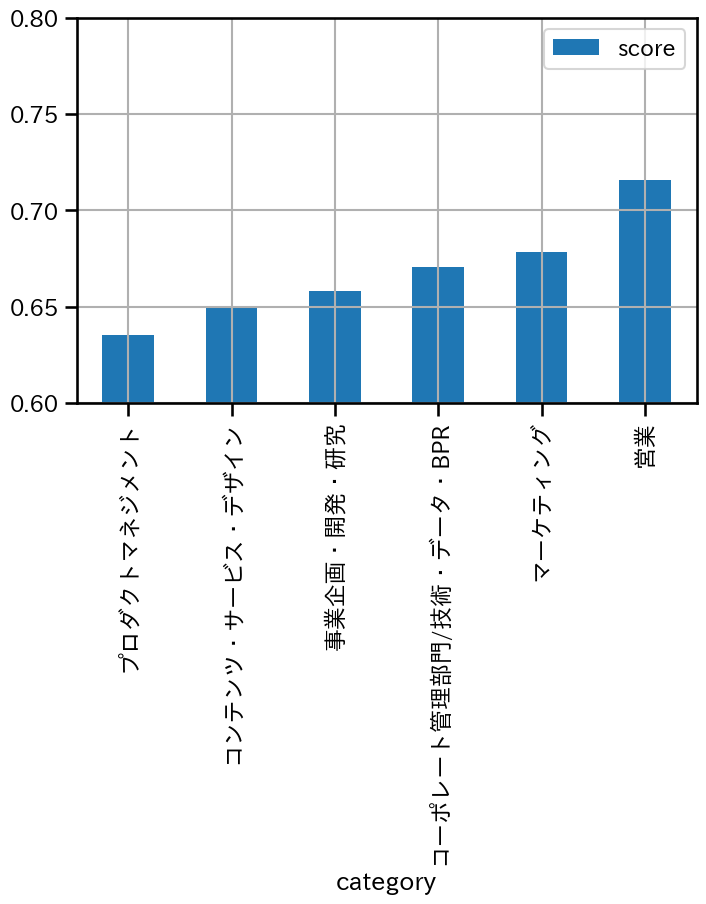

In [183]:
# Ë§áÊï∞„ÅÆ„Ç´„ÉÜ„Ç¥„É™„Åî„Å®„Å´ÂøúÂãüÊúâÁÑ°„Çí‰∫àÊ∏¨„Åó„Å™„Åè„Å¶„ÅØ„Å™„Çâ„Å™„ÅÑ
# „Å©„ÅÆ„Ç´„ÉÜ„Ç¥„É™„ÅÆ‰∫àÊ∏¨„ÅåÈõ£„Åó„Åè„Å¶„ÄÅ„Å©„ÅÆ„Ç´„ÉÜ„Ç¥„É™„ÅÆ‰∫àÊ∏¨„ÅåÁ∞°Âçò„Å™„ÅÆ„Åã„ÇíÊääÊè°„Åó„Å¶„Åä„Åè„Å®ËâØ„ÅÑ
scores = []
for cat_name, _df in df_train.groupby("category"):
    idx = _df.index
    score_i = roc_auc_score(df_train["target"].iloc[idx], oof[idx])

    scores.append({
        "category": cat_name,
        "score": score_i
    })

fig, ax = plt.subplots(figsize=(8,5))
pd.DataFrame(scores).set_index("category").sort_values("score").plot(kind="bar", ax=ax)
ax.set_ylim([.6, .8])
ax.grid()

# ÈÉ®ÁΩ≤„Åî„Å®„Å´„Å©„ÅÆ„Åè„Çâ„ÅÑ‰∫àÊ∏¨„Åå„ÅÇ„Åü„Å£„Å¶„ÅÑ„Çã„Åã„ÇíÁ¢∫Ë™ç„Åô„Çã„Åì„Å®„Åå„Åß„Åç„Çã„ÄÇ
# „Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞„Çí„Å©„ÅÜ„ÇÑ„Å£„Å¶‰∫àÊ∏¨„Åß„Åç„Çã„Åã„Å™„Å©„ÇíËÄÉ„Åà„Å¶„Åø„Çã‚ÜíÊñ∞„Åü„Å™ÁâπÂæ¥Èáè„ÇíËÄÉ„Åà„Çã

C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_6596\2005055128.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


Text(0.5, 1.0, 'Feature Importance (LightGBM)')

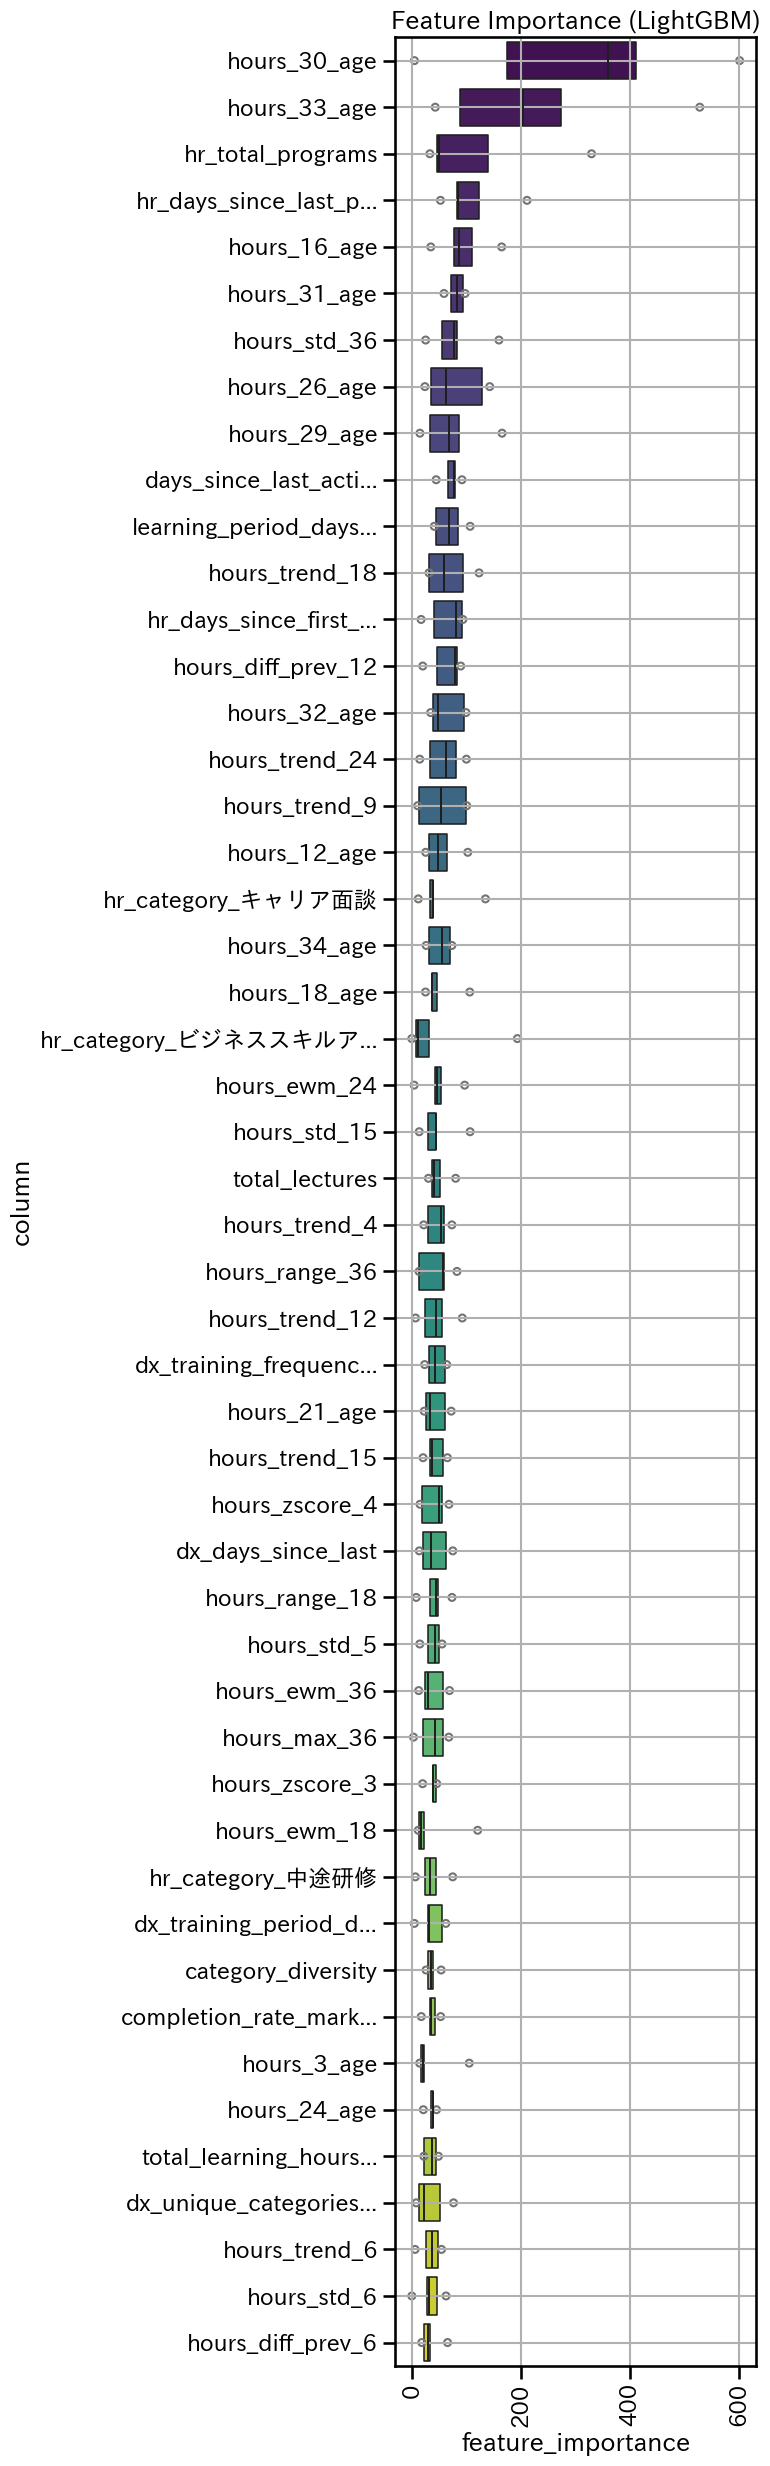

In [184]:
# ÁâπÂæ¥ÈáçË¶ÅÂ∫¶
# Â§ß‰∫ã„Å™ÁâπÂæ¥Èáè„Å®Â§ß‰∫ã„Åß„ÅØ„Å™„ÅÑÁâπÂæ¥Èáè„ÇíÊé¢„Åõ„Çã
# LightGBMÁî®„ÅÆÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶
def visualize_importance(models, feat_train_df):
    """lightGBM „ÅÆ model ÈÖçÂàó„ÅÆ feature importance „Çí plot „Åô„Çã
    CV„Åî„Å®„ÅÆ„Éñ„É¨„Çí boxen plot „Å®„Åó„Å¶Ë°®Áèæ„Åó„Åæ„Åô.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            Â≠¶ÁøíÊôÇ„Å´‰Ωø„Å£„Åü DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_

        columns = [c if len(c) < 20 else c[:20] + "..." for c in feat_train_df.columns]
        _df["column"] = columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)
    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .5)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h"
                  )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, X)
ax.set_title("Feature Importance (LightGBM)")

In [185]:
# ‰∫àÊ∏¨„Éï„Ç°„Ç§„É´„Çí‰Ωú„Çã„ÄÇ5„Åì‰∫àÊ∏¨„Éï„Ç°„Ç§„É´„Çí‰Ωú„Å£„Å¶„Åù„ÅÆÂπ≥Âùá„Åß„É¢„Éá„É´„ÅåÊßãÁØâ„Åï„Çå„Çã„ÄÇ
df_submission = pd.DataFrame()

predicts = [model.predict_proba(X_test.values)[:, 1]for model in models]
# 5„Å§„ÅÆ„É¢„Éá„É´„ÅÆ‰∫àÊ∏¨ÂÄ§„ÅÆÂπ≥Âùá„ÇíÂèñ„Çã
predict_avg = np.array(predicts).mean(axis=0)
# ÊèêÂá∫Áî®„Éá„Éº„Çø„Éï„É¨„Éº„É†„Çí‰ΩúÊàê
df_submission = pd.DataFrame({'target': predict_avg})

# 1. ÁèæÂú®„ÅÆÊó•ÊôÇ„ÇíÂèñÂæó
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"{timestamp}_submission.csv"

df_submission.to_csv(os.path.join(OUTPUT_DIR, filename),index=False)

In [186]:
# # --- 2. ÂêÑ„Éá„Éº„Çø„ÅÆÈõÜË®à„ÉªÂä†Â∑• ---

# # ÂøúÂãüËÄÖ„Éá„Éº„ÇøÔºà„Çø„Éº„Ç≤„ÉÉ„ÉàÔºâ„ÅÆ‰ΩúÊàê
# df_target = df_train.groupby('Á§æÂì°Áï™Âè∑')['target'].max().reset_index()

# # ÊúÄÊñ∞„ÅÆÂΩπËÅ∑„Éá„Éº„Çø„ÇíÊäΩÂá∫
# df_position_latest = df_position.sort_values('year').groupby('Á§æÂì°Áï™Âè∑').last().reset_index()

# # ÊÆãÊ•≠ÊôÇÈñì„ÅÆÂπ≥Âùá„ÇíÁÆóÂá∫
# df_overtime_avg = df_overtime.groupby('Á§æÂì°Áï™Âè∑')['hours'].mean().reset_index()
# df_overtime_avg = df_overtime_avg.rename(columns={'hours': 'ÊúàÂπ≥ÂùáÊÆãÊ•≠ÊôÇÈñì'})

# # Á†î‰øÆ(hr)„ÅÆÂèóË¨õÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà
# df_hr_count = df_hr.groupby('Á§æÂì°Áï™Âè∑').size().reset_index(name='Á†î‰øÆÂèóË¨õÂõûÊï∞')

# # DXÁ†î‰øÆ„ÅÆÂèóË¨õÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà
# df_dx_count = df_dx.groupby('Á§æÂì°Áï™Âè∑').size().reset_index(name='DXÁ†î‰øÆÂèóË¨õÂõûÊï∞')

# # Udemy„ÅÆ„Ç¢„ÇØ„ÉÜ„Ç£„Éì„ÉÜ„Ç£Êï∞„Çí„Ç´„Ç¶„É≥„Éà
# df_udemy_count = df_udemy.groupby('Á§æÂì°Áï™Âè∑').size().reset_index(name='Udemy„Ç¢„ÇØ„ÉÜ„Ç£„Éì„ÉÜ„Ç£Êï∞')

# # „Ç≠„É£„É™„Ç¢„Ç¢„É≥„Ç±„Éº„Éà„ÅÆ„Éá„Éº„Çø„ÇíÂä†Â∑•
# # „Ç´„É©„É†Âêç„ÇíÁü≠Á∏Æ (‰æã: career_q1, career_q2...)
# original_career_columns = df_career.columns.tolist()
# new_career_columns = {col: f'career_q{i}' for i, col in enumerate(original_career_columns)}
# df_career_processed = df_career.rename(columns=new_career_columns)
# df_career_processed = df_career_processed.rename(columns={'career_q0': 'Á§æÂì°Áï™Âè∑'}) # Á§æÂì°Áï™Âè∑„ÅÆ„Ç´„É©„É†Âêç„ÅØÂÖÉ„Å´Êàª„Åô

# # ÂõûÁ≠î„ÅÆÊñáÂ≠óÂàó„Åã„Çâ„Çπ„Ç≥„Ç¢ÔºàÊï∞Â≠óÔºâ„ÇíÊäΩÂá∫„Åô„ÇãÈñ¢Êï∞
# def extract_score(value):
#     if isinstance(value, str):
#         match = re.search(r'^(\d)', value.strip())
#         if match:
#             return int(match.group(1))
#     return None # Êï∞ÂÄ§„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅØNoneÔºàÊ¨†ÊêçÂÄ§Ôºâ

# # Á§æÂì°Áï™Âè∑‰ª•Â§ñ„ÅÆÂÖ®„Ç´„É©„É†„Å´ÈÅ©Áî®
# for col in df_career_processed.columns:
#     if col != 'Á§æÂì°Áï™Âè∑':
#         df_career_processed[col] = df_career_processed[col].apply(extract_score)


